# **PHASE IV - MODEL EVALUATION AND INTERPRETATION WITH SHAP AND LIME**


## **1. Load Splitted Datasets**

In [1]:
import os
import joblib
import shap
!pip install lime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
from scipy.stats import ks_2samp
from itertools import combinations
from sklearn.metrics import pairwise
from sklearn.metrics import confusion_matrix
from scipy.stats import spearmanr, kendalltau
from lime.lime_tabular import LimeTabularExplainer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, roc_curve, confusion_matrix

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=fa5cf4f78ea0ca9ebbe86c512306b922d1d9f9e773e2d5dd6afe9a8b347cc53a
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
os.listdir('/content/drive/MyDrive')

['Colab Notebooks',
 'LC_loans_granting_model_dataset.csv',
 'processed_loan_data.csv',
 'processed_loan_data.parquet',
 'LCDataDictionary.xlsx',
 'NOTE2.ipynb',
 'loan_2019_2020.csv',
 'loan_2019_2020_filtered.csv',
 'loan_2019_2020_final.csv',
 'Portfolio - Bertie Dickinson.ipynb',
 'd1_cleaned.csv',
 'categorical_variable_plots.png',
 'categorical_default_non_default_rate_plots.png',
 'Default_Rate_Of_Categorical_variable.png',
 'numerical_density_plots_by_default.png',
 'Categorical_Default_non_Default_Count.png',
 'Numerical_density_plots_by_default.png',
 'FE_data.csv',
 'Feature_Engineering_data.csv',
 'processed_dataset.xls',
 'Categorical_Default_non_Default_Rate.png',
 'PHASE_2_data.csv',
 'project_data',
 'Phase_2_data_splits',
 'Phase_2_data_preprocessed',
 'Phase_2_data_preprocessed_csv',
 'Phase_2_models',
 'sd_30.csv',
 'P1_data.csv',
 'Innitial Data Cleaning.ipynb',
 'P2_data.csv',
 'split_P2_data',
 'First.ipynb',
 'Phase_3_models']

In [4]:
# Path to your saved file
joblib_filename = "/content/drive/MyDrive/Phase_2_data_preprocessed/preprocessed_data.pkl"

# Load the dictionary
preprocessed_data = joblib.load(joblib_filename)

# Unpack the dictionary
X_train_df = preprocessed_data['X_train_df']
y_train = preprocessed_data['y_train']
X_val_df = preprocessed_data['X_val_df']
y_val = preprocessed_data['y_val']
X_test_df = preprocessed_data['X_test_df']
y_test = preprocessed_data['y_test']

print("✅ Preprocessed data loaded successfully.")

✅ Preprocessed data loaded successfully.


_

## **2. LOAD MODELS**

### **i. Logistic Regression Model**

In [5]:
# Path to your saved model file
model_filename = "/content/drive/MyDrive/Phase_2_models/best_logistic_regression_balanced.pkl"

# Load the model
logReg_model = joblib.load(model_filename)

print("✅ Model loaded successfully.")

✅ Model loaded successfully.


### **ii. Random Forest**

In [6]:
# Path to your saved model file
model_filename = "/content/drive/MyDrive/Phase_2_models/best_random_forest_auc.pkl"

# Load the model
RF_model = joblib.load(model_filename)

print("✅ Model loaded successfully.")

✅ Model loaded successfully.


### **iii. XGBoost**

In [7]:
# Path to your saved model file
model_filename = "/content/drive/MyDrive/Phase_2_models/best_xgboost_auc_early_stopping.pkl"

# Load the model
XG_model = joblib.load(model_filename)

print("✅ Model loaded successfully.")

✅ Model loaded successfully.


### **iv. LightGBM**

In [8]:
# Path to your saved model file
model_filename = "/content/drive/MyDrive/Phase_2_models/best_lightgbm_auc_early_stopping.pkl"

# Load the model
LGBM_model = joblib.load(model_filename)

print("✅ Model loaded successfully.")

✅ Model loaded successfully.


_

## **3. Evaluating Models**

Evaluating Logistic Regression...
Evaluating Random Forest...
Evaluating XGBoost...
Evaluating LightGBM...
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma


,Model,ROC_AUC,Accuracy,F1_Default,Precision_Default,Recall_Default,KS_Default,F1_NonDefault,Precision_NonDefault,Recall_NonDefault,KS_NonDefault
0,Logistic Regression,0.719268,0.659880,0.468461,0.363243,0.659490,0.320353,0.749934,0.868254,0.659994,0.320353
1,Random Forest,0.721822,0.735561,0.437361,0.423426,0.452245,0.324946,0.827164,0.835612,0.818886,0.324946
2,XGBoost,0.731284,0.657178,0.476133,0.364732,0.685510,0.336710,0.745226,0.875235,0.648845,0.336710
3,LightGBM,0.730705,0.656853,0.477323,0.365019,0.689439,0.337144,0.744584,0.876338,0.647270,0.337144


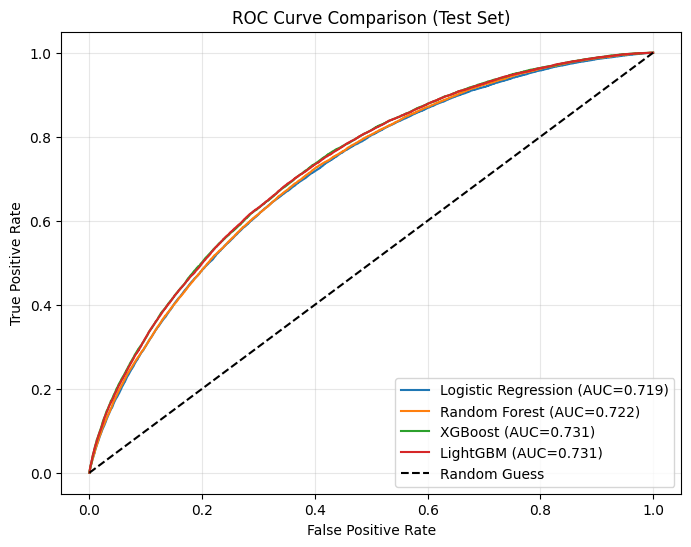

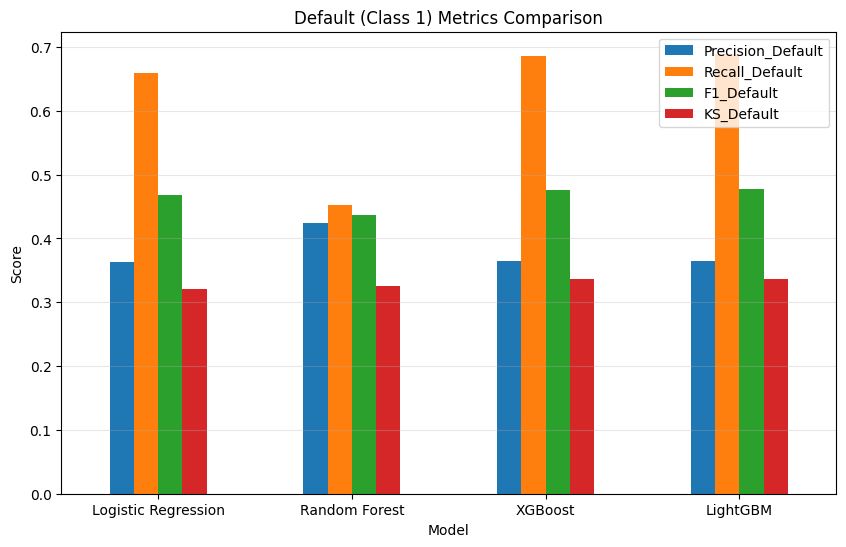

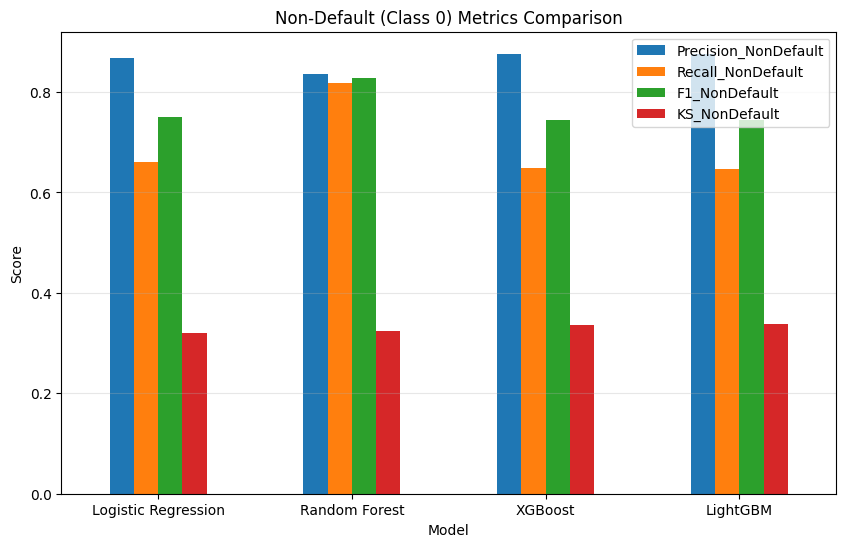

In [9]:
# ---------------------------
# Helper Function: Evaluate a Model
# ---------------------------
def evaluate_model(model, X, y, model_name):
    """Evaluate model and return metrics + data for plots."""
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]

    # Metrics for default class (1)
    roc_auc = roc_auc_score(y, y_proba)
    f1 = f1_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    accuracy = accuracy_score(y, y_pred)
    ks_stat, _ = ks_2samp(y_proba[y == 0], y_proba[y == 1])

    # Confusion matrix
    TN, FP, FN, TP = confusion_matrix(y, y_pred).ravel()

    # Non-default class (0) metrics
    precision_non_default = TN / (TN + FN) if (TN + FN) > 0 else 0
    recall_non_default = TN / (TN + FP) if (TN + FP) > 0 else 0
    f1_non_default = (
        2 * (precision_non_default * recall_non_default) /
        (precision_non_default + recall_non_default)
        if (precision_non_default + recall_non_default) > 0 else 0
    )

    # Store all metrics
    results = {
        'Model': model_name,
        'ROC_AUC': roc_auc,
        'Accuracy': accuracy,
        'F1_Default': f1,
        'Precision_Default': precision,
        'Recall_Default': recall,
        'KS_Default': ks_stat,
        'F1_NonDefault': f1_non_default,
        'Precision_NonDefault': precision_non_default,
        'Recall_NonDefault': recall_non_default,
        'KS_NonDefault': ks_stat  # same KS value
    }

    # ROC curve data
    fpr, tpr, _ = roc_curve(y, y_proba)
    return results, (fpr, tpr)

# ---------------------------
# Evaluate All Models on Test Set
# ---------------------------
models = {
    "Logistic Regression": logReg_model,
    "Random Forest": RF_model,
    "XGBoost": XG_model,
    "LightGBM": LGBM_model
}

results_list = []
roc_curves = {}

for model_name, model in models.items():
    print(f"Evaluating {model_name}...")
    metrics, roc_data = evaluate_model(model, X_test_df, y_test, model_name)
    results_list.append(metrics)
    roc_curves[model_name] = roc_data

# ---------------------------
# Create Results DataFrame
# ---------------------------
results_df = pd.DataFrame(results_list)
display(results_df)

# ---------------------------
# 1️⃣ ROC Curve Comparison
# ---------------------------
plt.figure(figsize=(8, 6))
for model_name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{model_name} (AUC={results_df.loc[results_df['Model']==model_name, 'ROC_AUC'].values[0]:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.title("ROC Curve Comparison (Test Set)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ---------------------------
# 2️⃣ Metric Comparison for DEFAULT (Class 1)
# ---------------------------
metrics_default = results_df[['Model', 'Precision_Default', 'Recall_Default', 'F1_Default', 'KS_Default']]
metrics_default.set_index('Model', inplace=True)
metrics_default.plot(kind='bar', figsize=(10, 6))
plt.title("Default (Class 1) Metrics Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

# ---------------------------
# 3️⃣ Metric Comparison for NON-DEFAULT (Class 0)
# ---------------------------
metrics_non_default = results_df[['Model', 'Precision_NonDefault', 'Recall_NonDefault', 'F1_NonDefault', 'KS_NonDefault']]
metrics_non_default.set_index('Model', inplace=True)
metrics_non_default.plot(kind='bar', figsize=(10, 6))
plt.title("Non-Default (Class 0) Metrics Comparison")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()


_

_

# **A. LIME STABILITY IN LOGISTIC REGRESSION MODEL**

## **1. Data Preparation**

In [10]:
# -------------------------------
# 1️⃣ Get predictions and identify true positives & true negatives
# -------------------------------
y_pred_lr = logReg_model.predict(X_test_df)
y_prob_lr = logReg_model.predict_proba(X_test_df)[:, 1]

# Confusion matrix helps identify TP, TN, FP, FN
tn_idx = (y_test == 0) & (y_pred_lr == 0)
tp_idx = (y_test == 1) & (y_pred_lr == 1)

# Get indices
true_positive_indices = np.where(tp_idx)[0]
true_negative_indices = np.where(tn_idx)[0]

# Sample 100 examples (50 TP + 50 TN)
np.random.seed(42)
sample_tp = np.random.choice(true_positive_indices, size=min(50, len(true_positive_indices)), replace=False)
sample_tn = np.random.choice(true_negative_indices, size=min(50, len(true_negative_indices)), replace=False)
sample_indices = np.concatenate([sample_tp, sample_tn])

print(f"✅ Sampled {len(sample_indices)} instances (TP+TN) for stability testing")

✅ Sampled 100 instances (TP+TN) for stability testing


In [11]:
# Get the y values for the sampled indices
y_sample = y_test.iloc[sample_indices]

# Display the head of the y values for the sample
display(y_sample.head())

# Display the shape of the y values for the sample
print(f"Shape of y_sample: {y_sample.shape}")

,default
136272,1
222953,1
316167,1
197307,1
132790,1


Shape of y_sample: (100,)


In [12]:
# Create a DataFrame of the sampled instances
sample_df = X_test_df.iloc[sample_indices].copy()

# Add some metadata columns
sample_df['true_label'] = y_test.iloc[sample_indices].values
sample_df['predicted_label'] = y_pred_lr[sample_indices]
sample_df['predicted_prob'] = y_prob_lr[sample_indices]

# reorder columns so metadata is visible first
cols = ['true_label', 'predicted_label', 'predicted_prob'] + list(X_test_df.columns)
sample_df = sample_df[cols]

# Display summary
print("✅ Sampled DataFrame created:")
display(sample_df.head(3))
print(f"\nShape: {sample_df.shape}")

✅ Sampled DataFrame created:


,true_label,predicted_label,predicted_prob,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,...,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_accts_ever_120_pd,num_bc_tl,num_rev_tl_bal_gt_0,pub_rec_bankruptcies,mo_sin_old_il_acct_missing,high_dti_risk
136272,1,1,0.615871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.308687,-0.642179,-0.898205,-0.872788,-0.466075,1.265794,1.846958,-0.399103,0.0,0.0
222953,1,1,0.516678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.102100,-0.894969,-0.898205,-0.872788,-0.466075,2.291340,-0.707673,-0.399103,0.0,0.0
316167,1,1,0.630397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.790725,0.958826,0.132156,1.683704,-0.466075,-0.785298,0.387169,-0.399103,0.0,0.0



Shape: (100, 81)


In [13]:
# View instance by index
sample_df.iloc[0]

,136272
true_label,1.000000
predicted_label,1.000000
predicted_prob,0.615871
emp_length_1 year,0.000000
emp_length_10+ years,0.000000
...,...
num_bc_tl,1.265794
num_rev_tl_bal_gt_0,1.846958
pub_rec_bankruptcies,-0.399103
mo_sin_old_il_acct_missing,0.000000


_

## **2. LOCAL STABILITY**

### **i. Across 100 instances with each instance ran 30 times**

In [78]:
# -------------------------------------
# 1️⃣ Initialize LIME Explainer once
# -------------------------------------
explainer = LimeTabularExplainer(
    training_data=np.array(X_train_df),
    feature_names=X_train_df.columns,
    class_names=["Negative", "Positive"],
    mode="classification",
    discretize_continuous=True
)

# -------------------------------------
# 2️⃣ Define helper for Jaccard similarity
# -------------------------------------
def jaccard_similarity(list1, list2):
    return len(set(list1) & set(list2)) / len(set(list1) | set(list2))

# -------------------------------------
# 3️⃣ Loop through all 100 instances
# -------------------------------------
lime_stability_results = []

for instance_id in range(100):  # or len(sample_df)
    instance_features = sample_df[X_test_df.columns].iloc[instance_id].values

    explanations = []
    for i in range(30):  # 30 runs
        np.random.seed(i)
        exp = explainer.explain_instance(
            data_row=instance_features,
            predict_fn=logReg_model.predict_proba,
            num_features=10
        )
        explanations.append(dict(exp.as_list()))

    df_expl = pd.DataFrame(explanations).fillna(0)

    # Cosine
    cosine_matrix = cosine_similarity(df_expl)
    mean_cosine = np.mean(cosine_matrix[np.triu_indices_from(cosine_matrix, 1)])

    # Spearman & Kendall
    spearman_corrs, kendall_corrs = [], []
    df_expl_filtered = df_expl[df_expl.var(axis=1) > 1e-9]
    if df_expl_filtered.shape[0] > 1:
        for i in range(df_expl_filtered.shape[0]):
            for j in range(i + 1, df_expl_filtered.shape[0]):
                s, _ = spearmanr(df_expl_filtered.iloc[i], df_expl_filtered.iloc[j])
                k, _ = kendalltau(df_expl_filtered.iloc[i], df_expl_filtered.iloc[j])
                spearman_corrs.append(s)
                kendall_corrs.append(k)
        mean_spearman = np.nanmean(spearman_corrs)
        mean_kendall = np.nanmean(kendall_corrs)
    else:
        mean_spearman = mean_kendall = np.nan

    # Jaccard
    top_features = [list(df_expl.iloc[i].abs().nlargest(5).index) for i in range(30)]
    jaccards = [
        jaccard_similarity(top_features[i], top_features[j])
        for i in range(30)
        for j in range(i + 1, 30)
    ]
    mean_jaccard = np.mean(jaccards)

    # Store result
    lime_stability_results.append({
        "instance_id": instance_id,
        "true_label": sample_df['true_label'].iloc[instance_id],
        "predicted_label": sample_df['predicted_label'].iloc[instance_id],
        "predicted_prob": sample_df['predicted_prob'].iloc[instance_id],
        "cosine": mean_cosine,
        "spearman": mean_spearman,
        "kendall": mean_kendall,
        "jaccard": mean_jaccard
    })

# -------------------------------------
# 4️⃣ Create final DataFrame
# -------------------------------------
lime_stability_df = pd.DataFrame(lime_stability_results)

# Save or inspect
print("\n🔹 LIME Stability Summary Across 100 Instances")
print(lime_stability_df.describe()[["cosine", "spearman", "kendall", "jaccard"]])


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature na


🔹 LIME Stability Summary Across 100 Instances
           cosine    spearman     kendall     jaccard
count  100.000000  100.000000  100.000000  100.000000
mean     0.954608    0.939899    0.882613    0.824352
std      0.015757    0.035689    0.050249    0.052139
min      0.917919    0.818608    0.713536    0.723153
25%      0.943352    0.924611    0.859865    0.795402
50%      0.956805    0.951065    0.895903    0.818391
75%      0.966510    0.961427    0.912414    0.841544
max      0.980098    0.992494    0.976693    0.937931


In [79]:
lime_stability_df.head()

,instance_id,true_label,predicted_label,predicted_prob,cosine,spearman,kendall,jaccard
0,0,1,1,0.615871,0.940871,0.901269,0.814640,0.841270
1,1,1,1,0.516678,0.950451,0.949735,0.895254,0.815435
2,2,1,1,0.630397,0.934396,0.818608,0.713536,0.777778
3,3,1,1,0.681285,0.970109,0.948565,0.893523,0.821456
4,4,1,1,0.839100,0.977217,0.961914,0.921325,0.889655


_

## **3. GLOBAL STABILITY**

### **i. 100 instances - entire dataset pooled together**

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature na


🔹 Global LIME Stability Summary Across All Instances
           cosine    spearman     kendall     jaccard
count  100.000000  100.000000  100.000000  100.000000
mean     0.954608    0.939899    0.882613    0.824352
std      0.015757    0.035689    0.050249    0.052139
min      0.917919    0.818608    0.713536    0.723153
25%      0.943352    0.924611    0.859865    0.795402
50%      0.956805    0.951065    0.895903    0.818391
75%      0.966510    0.961427    0.912414    0.841544
max      0.980098    0.992494    0.976693    0.937931


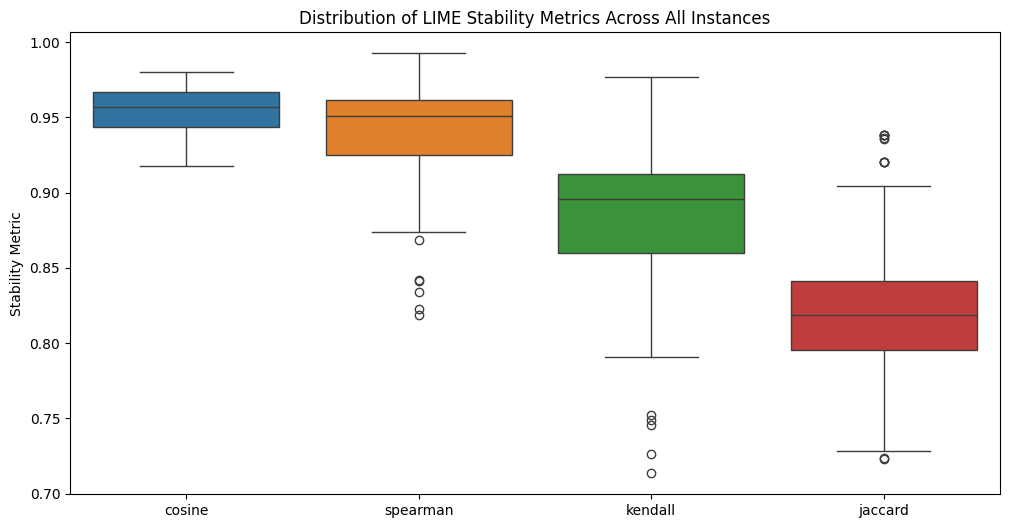

In [21]:
# -------------------------------------
# Parameters
# -------------------------------------
num_instances = len(sample_df)  # e.g., 100
num_runs = 30  # repeated LIME runs per instance
top_k = 5      # top features for Jaccard

# -------------------------------------
# Initialize LIME explainer once
# -------------------------------------
explainer = LimeTabularExplainer(
    training_data=np.array(X_train_df),
    feature_names=X_train_df.columns,
    class_names=["Negative", "Positive"],
    mode="classification",
    discretize_continuous=True
)

# -------------------------------------
# Helper function: Jaccard similarity
# -------------------------------------
def jaccard_similarity(list1, list2):
    return len(set(list1) & set(list2)) / len(set(list1) | set(list2))

# -------------------------------------
# Storage for metrics
# -------------------------------------
stability_results = []

# -------------------------------------
# Loop over all instances
# -------------------------------------
for instance_id in range(num_instances):
    instance_features = sample_df[X_test_df.columns].iloc[instance_id].values

    # Generate multiple LIME explanations
    explanations = []
    for i in range(num_runs):
        np.random.seed(i)
        exp = explainer.explain_instance(
            data_row=instance_features,
            predict_fn=logReg_model.predict_proba,
            num_features=10
        )
        explanations.append(dict(exp.as_list()))

    # Convert to DataFrame
    df_expl = pd.DataFrame(explanations).fillna(0)

    # Cosine similarity
    cosine_matrix = pairwise.cosine_similarity(df_expl)
    mean_cosine_stability = np.mean(cosine_matrix[np.triu_indices_from(cosine_matrix, 1)])

    # Spearman & Kendall correlations
    spearman_corrs, kendall_corrs = [], []
    df_filtered = df_expl.loc[df_expl.var(axis=1) > 1e-9]

    if df_filtered.shape[0] > 1:
        for i in range(df_filtered.shape[0]):
            for j in range(i + 1, df_filtered.shape[0]):
                s, _ = spearmanr(df_filtered.iloc[i], df_filtered.iloc[j])
                k, _ = kendalltau(df_filtered.iloc[i], df_filtered.iloc[j])
                spearman_corrs.append(s)
                kendall_corrs.append(k)
        mean_spearman = np.nanmean(spearman_corrs)
        mean_kendall = np.nanmean(kendall_corrs)
    else:
        mean_spearman = np.nan
        mean_kendall = np.nan

    # Jaccard similarity for top features
    top_features = [list(df_expl.iloc[i].abs().nlargest(top_k).index) for i in range(num_runs)]
    jaccards = [
        jaccard_similarity(top_features[i], top_features[j])
        for i in range(num_runs) for j in range(i + 1, num_runs)
    ]
    mean_jaccard = np.mean(jaccards)

    # Store results
    stability_results.append({
        "instance_id": instance_id,
        "true_label": sample_df['true_label'].iloc[instance_id],
        "pred_label": sample_df['predicted_label'].iloc[instance_id],
        "pred_prob": sample_df['predicted_prob'].iloc[instance_id],
        "cosine": mean_cosine_stability,
        "spearman": mean_spearman,
        "kendall": mean_kendall,
        "jaccard": mean_jaccard
    })

# -------------------------------------
# Summary table
# -------------------------------------
stability_df = pd.DataFrame(stability_results)

print("\n🔹 Global LIME Stability Summary Across All Instances")
print(stability_df.describe()[["cosine", "spearman", "kendall", "jaccard"]])

# Optional: visualisation of distributions
plt.figure(figsize=(12, 6))
sns.boxplot(data=stability_df[["cosine", "spearman", "kendall", "jaccard"]])
plt.title("Distribution of LIME Stability Metrics Across All Instances")
plt.ylabel("Stability Metric")
plt.show()


_

# **B. LIME STABILITY IN XGBOOST MODEL**

## **1. Data Preparation**

Will use thesame subset of the test set used for the logistic regression model.
Firstly, I'll evaluate the xgboost model predictions of that dataset to see if it aligns with the predictions of the logistic regression model. If it doesn't, I'll indicate the instances where the xgboost model's predictions are wrong.

In [31]:
# Create a DataFrame of the sampled instances
sample_100 = X_test_df.iloc[sample_indices].copy()

# Display summary
print("✅ Sampled DataFrame created:")
display(sample_100.head(3))
print(f"\nShape: {sample_100.shape}")

✅ Sampled DataFrame created:


,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,...,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_accts_ever_120_pd,num_bc_tl,num_rev_tl_bal_gt_0,pub_rec_bankruptcies,mo_sin_old_il_acct_missing,high_dti_risk
136272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.308687,-0.642179,-0.898205,-0.872788,-0.466075,1.265794,1.846958,-0.399103,0.0,0.0
222953,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.102100,-0.894969,-0.898205,-0.872788,-0.466075,2.291340,-0.707673,-0.399103,0.0,0.0
316167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.790725,0.958826,0.132156,1.683704,-0.466075,-0.785298,0.387169,-0.399103,0.0,0.0



Shape: (100, 78)


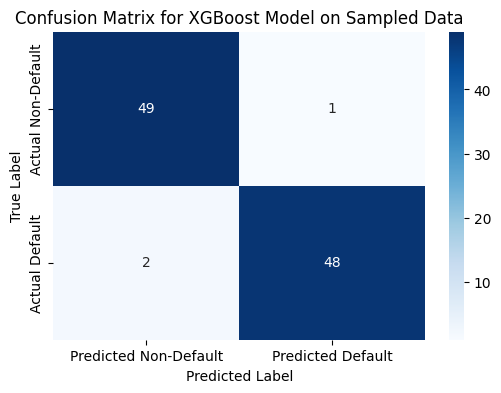

In [32]:
# Use the XGBoost model to predict on sample_df2
y_pred_xg = XG_model.predict(sample_100)

# Compute the confusion matrix
cm_xg = confusion_matrix(y_sample, y_pred_xg)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_xg, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Non-Default', 'Predicted Default'],
            yticklabels=['Actual Non-Default', 'Actual Default'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for XGBoost Model on Sampled Data')
plt.show()

There are 3 wrong predictions. So i'll copy the sample data and create new columns to specify the indices where xgboost predictions are wrong.

In [24]:
# Get the indices where predictions are wrong
incorrect_indices = sample_100.index[y_pred_xg != y_sample]

# Display the number of incorrect predictions
print(f"Number of incorrect predictions on the sampled data: {len(incorrect_indices)}")

# Display the indices of incorrect predictions
print("Indices of incorrect predictions:")
display(incorrect_indices)

Number of incorrect predictions on the sampled data: 3
Indices of incorrect predictions:


Index([313121, 150668, 252930], dtype='int64')

In [25]:
# Create sample_df1 as a copy of sample_df
sample_df1 = sample_df.copy()

# Add the new columns with y_sample, XGBoost predicted value, and XGBoost predicted probability
# Ensure the indices align correctly
sample_df1['true_y_sample'] = y_sample.values # Use y_sample directly as its index aligns with sample_df1
sample_df1['xg_predicted_label'] = y_pred_xg
sample_df1['xg_predicted_prob'] = XG_model.predict_proba(sample_100)[:, 1] # Predict probabilities using the XG_model on sample_df2

# Optional: reorder columns to place the new ones at the beginning
cols_sample1 = ['true_y_sample', 'xg_predicted_label', 'xg_predicted_prob'] + [col for col in sample_df1.columns if col not in ['true_y_sample', 'xg_predicted_label', 'xg_predicted_prob']]
sample_df1 = sample_df1[cols_sample1]

# Display the head of the new DataFrame
print("✅ sample_df1 created with XGBoost predictions:")
display(sample_df1.head())
print(f"\nShape: {sample_df1.shape}")

✅ sample_df1 created with XGBoost predictions:


,true_y_sample,xg_predicted_label,xg_predicted_prob,true_label,predicted_label,predicted_prob,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,...,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_accts_ever_120_pd,num_bc_tl,num_rev_tl_bal_gt_0,pub_rec_bankruptcies,mo_sin_old_il_acct_missing,high_dti_risk
136272,1,1,0.619614,1,1,0.615871,0.0,0.0,0.0,0.0,...,-0.308687,-0.642179,-0.898205,-0.872788,-0.466075,1.265794,1.846958,-0.399103,0.0,0.0
222953,1,1,0.545894,1,1,0.516678,0.0,0.0,0.0,0.0,...,-0.102100,-0.894969,-0.898205,-0.872788,-0.466075,2.291340,-0.707673,-0.399103,0.0,0.0
316167,1,1,0.590017,1,1,0.630397,0.0,0.0,0.0,0.0,...,-0.790725,0.958826,0.132156,1.683704,-0.466075,-0.785298,0.387169,-0.399103,0.0,0.0
197307,1,1,0.802422,1,1,0.681285,0.0,0.0,0.0,0.0,...,-1.307193,-0.810706,-0.726478,1.044581,0.748191,-0.785298,-0.342726,-0.399103,0.0,0.0
132790,1,1,0.840350,1,1,0.839100,0.0,1.0,0.0,0.0,...,-1.180945,-0.979233,-1.069932,1.044581,-0.466075,-0.016138,-0.342726,-0.399103,0.0,0.0



Shape: (100, 84)


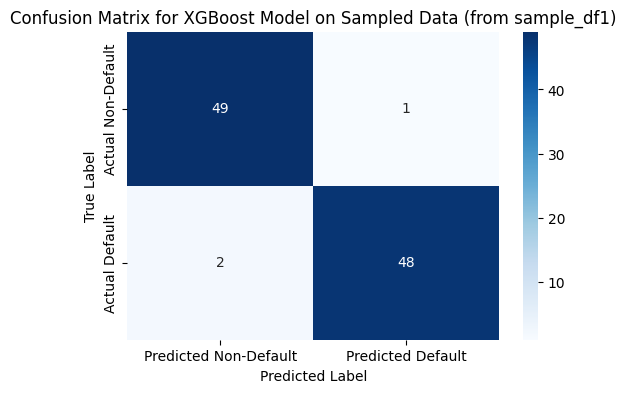

In [26]:
# Compute the confusion matrix using the columns from sample_df1
cm_sample1_xg = confusion_matrix(sample_df1['true_y_sample'], sample_df1['xg_predicted_label'])

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_sample1_xg, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Non-Default', 'Predicted Default'],
            yticklabels=['Actual Non-Default', 'Actual Default'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for XGBoost Model on Sampled Data (from sample_df1)')
plt.show()

Was done successfully. Now lets check lime explanations for 1 instances repeatedly.

_

## **2. LOCAL STABILITY**

### **i. Across 100 instances with each instance ran 30 times**

In [81]:
# Function to compute Jaccard similarity
def jaccard_similarity(list1, list2):
    return len(set(list1) & set(list2)) / len(set(list1) | set(list2))

# Initialize LIME Explainer once
explainer = LimeTabularExplainer(
    training_data=np.array(X_train_df),
    feature_names=X_train_df.columns,
    class_names=["Negative", "Positive"],
    mode="classification",
    discretize_continuous=True
)

# Loop over all instances
lime_results = []
num_runs = 30

for instance_id in range(len(sample_df1)):
    instance_features = sample_df1[X_test_df.columns].iloc[instance_id].values
    explanations = []

    for i in range(num_runs):
        np.random.seed(i)
        exp = explainer.explain_instance(
            data_row=instance_features,
            predict_fn=XG_model.predict_proba,
            num_features=10
        )
        explanations.append(dict(exp.as_list()))

    df_expl = pd.DataFrame(explanations).fillna(0)

    # ➕ Cosine similarity
    cosine_matrix = pairwise.cosine_similarity(df_expl)
    mean_cosine = np.mean(cosine_matrix[np.triu_indices_from(cosine_matrix, 1)])

    # ➕ Spearman & Kendall correlations
    df_filtered = df_expl.loc[df_expl.var(axis=1) > 1e-9]
    if df_filtered.shape[0] > 1:
        spearman_corrs, kendall_corrs = [], []
        for i in range(df_filtered.shape[0]):
            for j in range(i + 1, df_filtered.shape[0]):
                s, _ = spearmanr(df_filtered.iloc[i], df_filtered.iloc[j])
                k, _ = kendalltau(df_filtered.iloc[i], df_filtered.iloc[j])
                spearman_corrs.append(s)
                kendall_corrs.append(k)
        mean_spearman = np.nanmean(spearman_corrs)
        mean_kendall = np.nanmean(kendall_corrs)
    else:
        mean_spearman = np.nan
        mean_kendall = np.nan

    # ➕ Jaccard similarity (top 5 features)
    top_features = [list(df_expl.iloc[i].abs().nlargest(5).index) for i in range(num_runs)]
    jaccards = [
        jaccard_similarity(top_features[i], top_features[j])
        for i in range(num_runs)
        for j in range(i + 1, num_runs)
    ]
    mean_jaccard = np.mean(jaccards)

    # Save results
    lime_results.append({
        "instance_id": instance_id,
        "true_label": sample_df1['true_y_sample'].iloc[instance_id],
        "predicted_label": sample_df1['xg_predicted_label'].iloc[instance_id],
        "predicted_prob": sample_df1['xg_predicted_prob'].iloc[instance_id],
        "cosine": mean_cosine,
        "spearman": mean_spearman,
        "kendall": mean_kendall,
        "jaccard": mean_jaccard
    })

# Save to DataFrame
lime_stability_xgb = pd.DataFrame(lime_results)

# 🔹 Save or inspect
print("\n🔹 LIME Stability Summary Across 100 Instances")
print(lime_stability_xgb.describe()[["cosine", "spearman", "kendall", "jaccard"]])



🔹 LIME Stability Summary Across 100 Instances
           cosine    spearman     kendall     jaccard
count  100.000000  100.000000  100.000000  100.000000
mean     0.939594    0.900538    0.833460    0.787784
std      0.020020    0.040057    0.044624    0.072692
min      0.877408    0.745263    0.675387    0.654926
25%      0.928925    0.887572    0.813432    0.717570
50%      0.944579    0.911609    0.842013    0.801628
75%      0.954872    0.926428    0.864193    0.855364
max      0.968264    0.954883    0.904171    0.915380


In [ ]:
lime_stability_xgb.head()

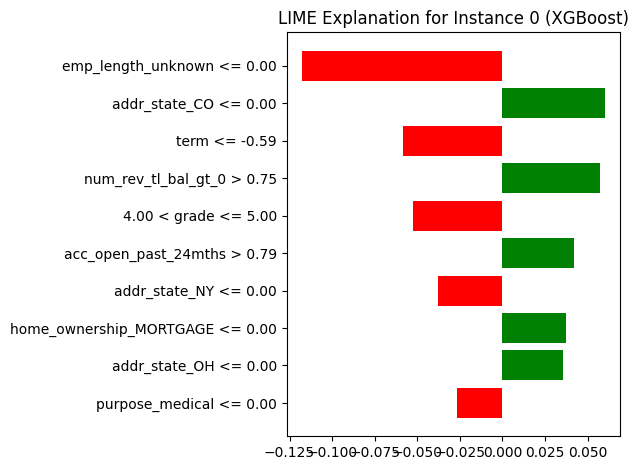

In [82]:
# Pick one instance for explanation
instance_id = 0
instance_features = sample_df1[X_test_df.columns].iloc[instance_id].values

# Explain once (no need to repeat)
exp = explainer.explain_instance(
    data_row=instance_features,
    predict_fn=XG_model.predict_proba,
    num_features=10
)

# 📊 Plot LIME explanation
fig = exp.as_pyplot_figure()
plt.title(f"LIME Explanation for Instance {instance_id} (XGBoost)")
plt.tight_layout()
plt.show()


_

## **3. GLOBAL STABILITY**

### **i. 100 instances - entire dataset pooled together**


🔹 Global LIME Stability Summary for XGBoost Model
           cosine    spearman     kendall     jaccard
count  100.000000  100.000000  100.000000  100.000000
mean     0.939594    0.900538    0.833460    0.787784
std      0.020020    0.040057    0.044624    0.072692
min      0.877408    0.745263    0.675387    0.654926
25%      0.928925    0.887572    0.813432    0.717570
50%      0.944579    0.911609    0.842013    0.801628
75%      0.954872    0.926428    0.864193    0.855364
max      0.968264    0.954883    0.904171    0.915380


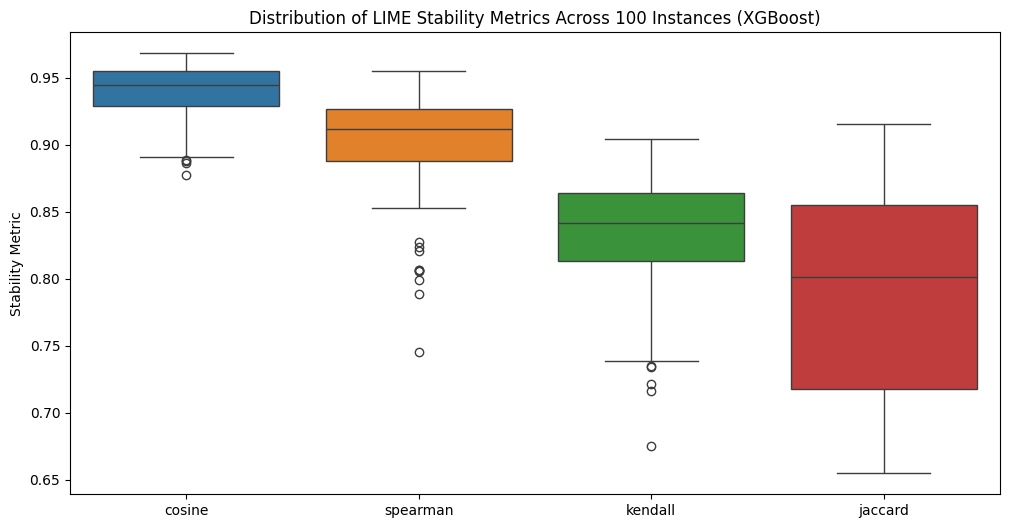

In [26]:
# -------------------------------------
# Parameters
# -------------------------------------
num_instances = len(sample_df1)  # e.g., 100
num_runs = 30  # repeated LIME runs per instance
top_k = 5      # top features for Jaccard

# -------------------------------------
# Initialize LIME explainer once
# -------------------------------------
explainer = LimeTabularExplainer(
    training_data=np.array(X_train_df),
    feature_names=X_train_df.columns,
    class_names=["Negative", "Positive"],
    mode="classification",
    discretize_continuous=True
)

# -------------------------------------
# Helper function: Jaccard similarity
# -------------------------------------
def jaccard_similarity(list1, list2):
    return len(set(list1) & set(list2)) / len(set(list1) | set(list2))

# -------------------------------------
# Storage for metrics
# -------------------------------------
stability_results = []

# -------------------------------------
# Loop over all instances
# -------------------------------------
for instance_id in range(num_instances):
    instance_features = sample_df1[X_train_df.columns].iloc[instance_id].values

    # Generate multiple LIME explanations
    explanations = []
    for i in range(num_runs):
        np.random.seed(i)
        exp = explainer.explain_instance(
            data_row=instance_features,
            predict_fn=XG_model.predict_proba,  # XGBoost model
            num_features=10
        )
        explanations.append(dict(exp.as_list()))

    # Convert to DataFrame
    df_expl = pd.DataFrame(explanations).fillna(0)

    # Cosine similarity
    cosine_matrix = pairwise.cosine_similarity(df_expl)
    mean_cosine = np.mean(cosine_matrix[np.triu_indices_from(cosine_matrix, 1)])

    # Spearman & Kendall correlations
    spearman_corrs, kendall_corrs = [], []
    df_filtered = df_expl.loc[df_expl.var(axis=1) > 1e-9]

    if df_filtered.shape[0] > 1:
        for i in range(df_filtered.shape[0]):
            for j in range(i + 1, df_filtered.shape[0]):
                s, _ = spearmanr(df_filtered.iloc[i], df_filtered.iloc[j])
                k, _ = kendalltau(df_filtered.iloc[i], df_filtered.iloc[j])
                spearman_corrs.append(s)
                kendall_corrs.append(k)
        mean_spearman = np.nanmean(spearman_corrs)
        mean_kendall = np.nanmean(kendall_corrs)
    else:
        mean_spearman = np.nan
        mean_kendall = np.nan

    # Jaccard similarity for top features
    top_features = [list(df_expl.iloc[i].abs().nlargest(top_k).index) for i in range(num_runs)]
    jaccards = [
        jaccard_similarity(top_features[i], top_features[j])
        for i in range(num_runs) for j in range(i + 1, num_runs)
    ]
    mean_jaccard = np.mean(jaccards)

    # Store results
    stability_results.append({
        "instance_id": instance_id,
        "true_label": sample_df1['true_y_sample'].iloc[instance_id],
        "pred_label": sample_df1['xg_predicted_label'].iloc[instance_id],
        "pred_prob": sample_df1['xg_predicted_prob'].iloc[instance_id],
        "cosine": mean_cosine,
        "spearman": mean_spearman,
        "kendall": mean_kendall,
        "jaccard": mean_jaccard
    })

# -------------------------------------
# Summary table
# -------------------------------------
stability_df = pd.DataFrame(stability_results)

print("\n🔹 Global LIME Stability Summary for XGBoost Model")
print(stability_df.describe()[["cosine", "spearman", "kendall", "jaccard"]])

# Optional: visualisation of distributions
plt.figure(figsize=(12, 6))
sns.boxplot(data=stability_df[["cosine", "spearman", "kendall", "jaccard"]])
plt.title("Distribution of LIME Stability Metrics Across 100 Instances (XGBoost)")
plt.ylabel("Stability Metric")
plt.show()

_

# **C. SHAP STABILITY IN LOGISTIC REGRESSION MODEL**

## **1. Local Stability - Across 100 samples, 30 run times for each sample**

In [83]:
# Jaccard similarity function
def jaccard_similarity(list1, list2):
    return len(set(list1) & set(list2)) / len(set(list1) | set(list2))

# SHAP Explainer for Logistic Regression
explainer_shap = shap.LinearExplainer(model=logReg_model, masker=X_train_df)

# Loop through all 100 instances
num_runs = 30
shap_stability_results = []

for instance_id in range(len(sample_df)):  # Assuming sample_df has 100 instances
    instance_features = X_test_df.iloc[[instance_id]]
    shap_values_list = []

    for i in range(num_runs):
        shap_values = explainer_shap(instance_features)
        shap_row = shap_values[0].values
        shap_dict = dict(zip(X_test_df.columns, shap_row))
        shap_values_list.append(shap_dict)

    df_shap = pd.DataFrame(shap_values_list).fillna(0)

    # Cosine similarity
    cosine_matrix = cosine_similarity(df_shap.values)
    mean_cosine = np.mean(cosine_matrix[np.triu_indices_from(cosine_matrix, 1)])

    # Spearman & Kendall
    spearman_corrs, kendall_corrs = [], []
    df_filtered = df_shap[df_shap.var(axis=1) > 1e-9]
    if df_filtered.shape[0] > 1:
        for i in range(df_filtered.shape[0]):
            for j in range(i + 1, df_filtered.shape[0]):
                s, _ = spearmanr(df_filtered.iloc[i], df_filtered.iloc[j])
                k, _ = kendalltau(df_filtered.iloc[i], df_filtered.iloc[j])
                spearman_corrs.append(s)
                kendall_corrs.append(k)
        mean_spearman = np.nanmean(spearman_corrs)
        mean_kendall = np.nanmean(kendall_corrs)
    else:
        mean_spearman = np.nan
        mean_kendall = np.nan

    # Jaccard similarity (top 5)
    top_features = [list(df_shap.iloc[i].abs().nlargest(5).index) for i in range(num_runs)]
    jaccards = [
        jaccard_similarity(top_features[i], top_features[j])
        for i in range(num_runs)
        for j in range(i + 1, num_runs)
    ]
    mean_jaccard = np.mean(jaccards)

    # Store result
    shap_stability_results.append({
        "instance_id": instance_id,
        "true_label": sample_df['true_label'].iloc[instance_id],
        "predicted_label": sample_df['predicted_label'].iloc[instance_id],
        "predicted_prob": sample_df['predicted_prob'].iloc[instance_id],
        "cosine": mean_cosine,
        "spearman": mean_spearman,
        "kendall": mean_kendall,
        "jaccard": mean_jaccard
    })

# 📊 Create DataFrame
shap_stability_lr = pd.DataFrame(shap_stability_results)

# ✅ Summary of SHAP stability across all instances
print("\n🔹 SHAP Stability Summary Across 100 Instances")
print(shap_stability_lr.describe()[["cosine", "spearman", "kendall", "jaccard"]])



🔹 SHAP Stability Summary Across 100 Instances
             cosine  spearman  kendall  jaccard
count  1.000000e+02     100.0    100.0    100.0
mean   1.000000e+00       1.0      1.0      1.0
std    1.739385e-16       0.0      0.0      0.0
min    1.000000e+00       1.0      1.0      1.0
25%    1.000000e+00       1.0      1.0      1.0
50%    1.000000e+00       1.0      1.0      1.0
75%    1.000000e+00       1.0      1.0      1.0
max    1.000000e+00       1.0      1.0      1.0


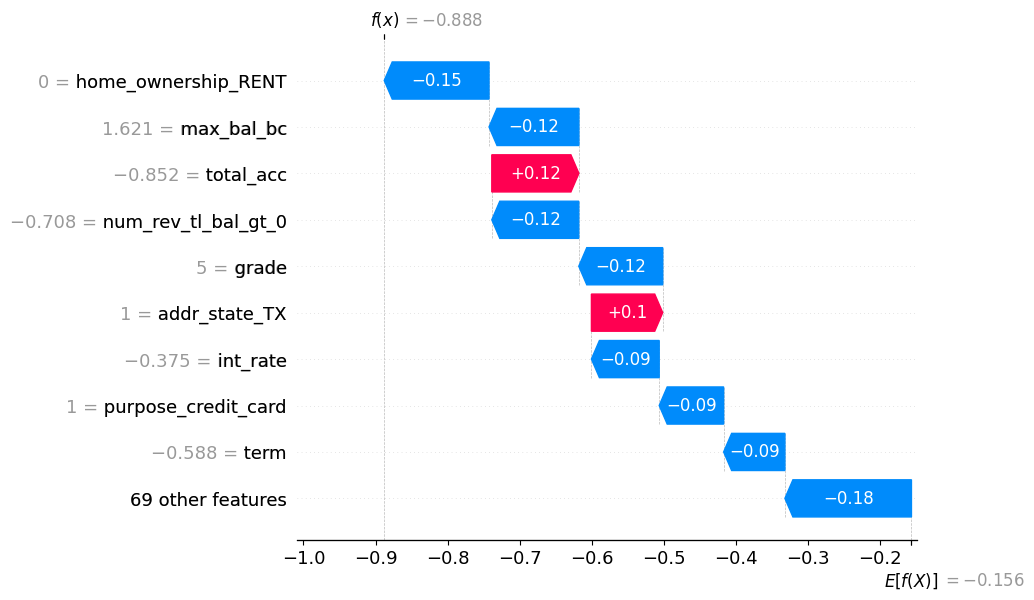

In [84]:
# Pick one instance for visualization
instance_id = 0
shap_values = explainer_shap(X_test_df.iloc[[instance_id]])
shap.plots.waterfall(shap_values[0])

_

## **2. Local Stability - Across 100 samples, 30 run times for each sample with gaussian noise, 0.01**

In [85]:
# ⚙️ Parameters
num_runs = 30
top_k = 5
noise_std = 0.01  # Gaussian noise std

# Define Jaccard similarity function
def jaccard_similarity(list1, list2):
    return len(set(list1) & set(list2)) / len(set(list1) | set(list2))

# Initialize SHAP explainer
explainer_shap = shap.LinearExplainer(model=logReg_model, masker=X_train_df)

# Store all results
shap_noise_stability_results = []

# Loop over all 100 instances
for instance_id in range(len(sample_df)):
    instance_features = sample_df[X_test_df.columns].iloc[[instance_id]]  # Keep as DataFrame

    shap_values_list = []

    for i in range(num_runs):
        np.random.seed(i)
        noisy_instance = instance_features + np.random.normal(0, noise_std, instance_features.shape)
        shap_values = explainer_shap(noisy_instance)
        shap_row = shap_values[0].values
        shap_dict = dict(zip(X_test_df.columns, shap_row))
        shap_values_list.append(shap_dict)

    df_shap = pd.DataFrame(shap_values_list).fillna(0)

    # Cosine similarity
    cosine_matrix = cosine_similarity(df_shap.values)
    mean_cosine = np.mean(cosine_matrix[np.triu_indices_from(cosine_matrix, 1)])

    # Spearman & Kendall
    spearman_corrs, kendall_corrs = [], []
    df_filtered = df_shap[df_shap.var(axis=1) > 1e-9]

    if df_filtered.shape[0] > 1:
        for i in range(df_filtered.shape[0]):
            for j in range(i + 1, df_filtered.shape[0]):
                s, _ = spearmanr(df_filtered.iloc[i], df_filtered.iloc[j])
                k, _ = kendalltau(df_filtered.iloc[i], df_filtered.iloc[j])
                spearman_corrs.append(s)
                kendall_corrs.append(k)

        mean_spearman = np.nanmean(spearman_corrs)
        mean_kendall = np.nanmean(kendall_corrs)
    else:
        mean_spearman = mean_kendall = np.nan

    # Jaccard (Top k)
    top_features = [list(df_shap.iloc[i].abs().nlargest(top_k).index) for i in range(num_runs)]
    jaccards = [
        jaccard_similarity(top_features[i], top_features[j])
        for i in range(num_runs)
        for j in range(i + 1, num_runs)
    ]
    mean_jaccard = np.mean(jaccards)

    # Save results
    shap_noise_stability_results.append({
        "instance_id": instance_id,
        "true_label": sample_df['true_label'].iloc[instance_id],
        "predicted_label": sample_df['predicted_label'].iloc[instance_id],
        "predicted_prob": sample_df['predicted_prob'].iloc[instance_id],
        "cosine": mean_cosine,
        "spearman": mean_spearman,
        "kendall": mean_kendall,
        "jaccard": mean_jaccard
    })

# Results DataFrame
shap_noise_stability_lr = pd.DataFrame(shap_noise_stability_results)

# Summary
print("\n🔹 SHAP Stability with Noise Across 100 Instances (LogReg)")
print(shap_noise_stability_lr.describe()[["cosine", "spearman", "kendall", "jaccard"]])



🔹 SHAP Stability with Noise Across 100 Instances (LogReg)
           cosine    spearman     kendall     jaccard
count  100.000000  100.000000  100.000000  100.000000
mean     0.999710    0.994257    0.969677    0.981157
std      0.000136    0.000843    0.002937    0.050139
min      0.999312    0.991444    0.960333    0.818391
25%      0.999650    0.994034    0.968275    1.000000
50%      0.999730    0.994272    0.969811    1.000000
75%      0.999816    0.994492    0.970979    1.000000
max      0.999911    0.997103    0.978187    1.000000


In [ ]:
shap_noise_stability_lr

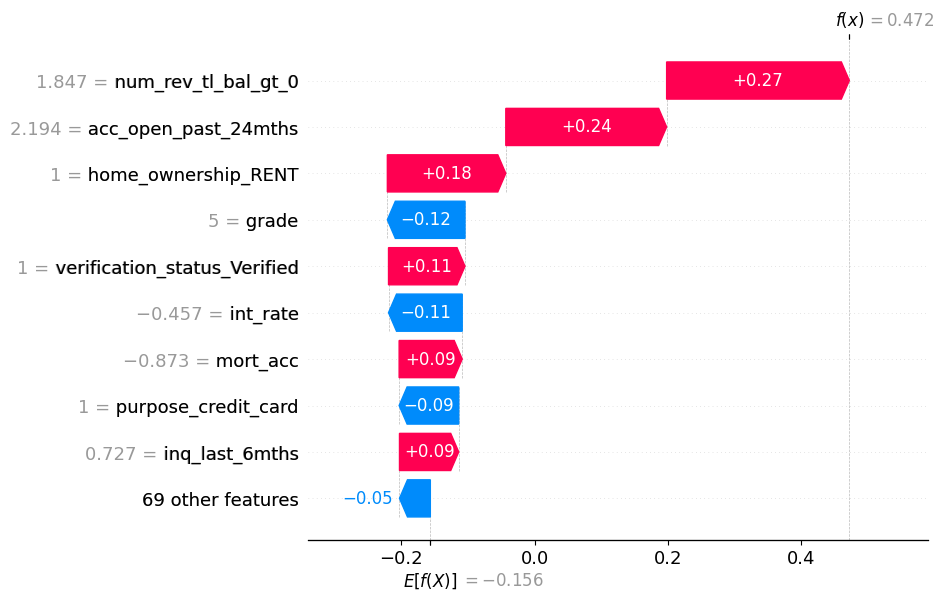

In [86]:
# Run SHAP once more for instance 0 to plot
instance_id = 0
instance_features = sample_df[X_test_df.columns].iloc[[instance_id]]
shap_values = explainer_shap(instance_features)
shap.plots.waterfall(shap_values[0])


_

## **3. Global Stability**


🔹 SHAP Stability Summary Across All Instances
             cosine  spearman  kendall  jaccard
count  1.000000e+02     100.0    100.0    100.0
mean   1.000000e+00       1.0      1.0      1.0
std    1.739385e-16       0.0      0.0      0.0
min    1.000000e+00       1.0      1.0      1.0
25%    1.000000e+00       1.0      1.0      1.0
50%    1.000000e+00       1.0      1.0      1.0
75%    1.000000e+00       1.0      1.0      1.0
max    1.000000e+00       1.0      1.0      1.0


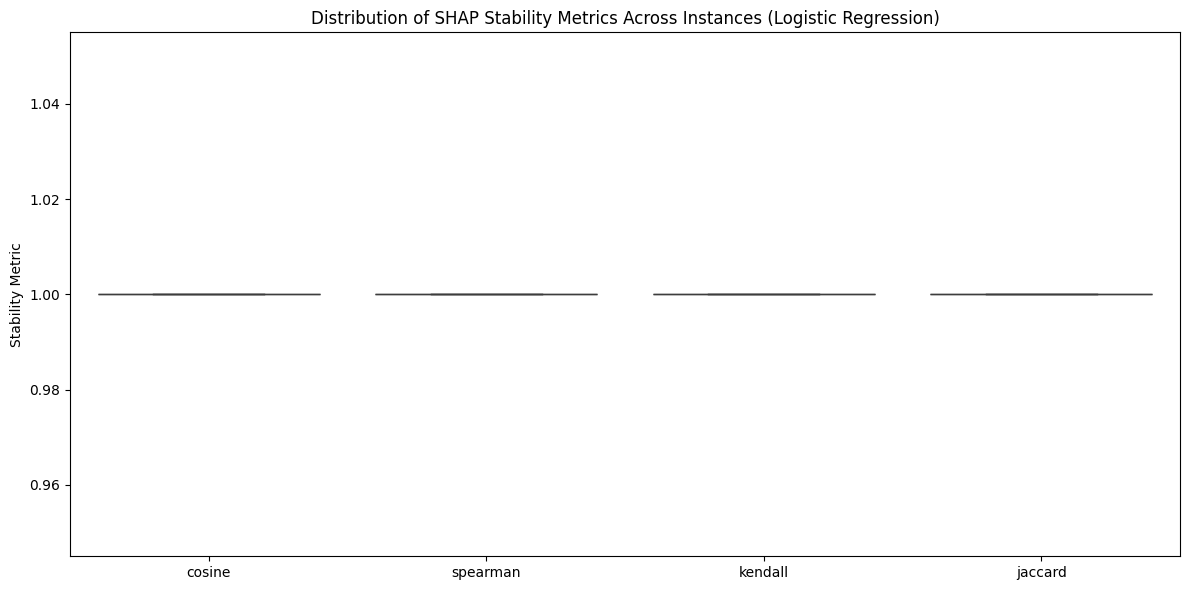

In [37]:
# -------------------------------------
# Parameters
# -------------------------------------
num_instances = len(sample_df)
num_runs = 30       # Repeated SHAP runs per instance
top_k = 5           # Top features for Jaccard similarity

# -------------------------------------
# Initialize SHAP LinearExplainer
# -------------------------------------
shap_explainer = shap.LinearExplainer(logReg_model, X_train_df)

# -------------------------------------
# Helper: Jaccard similarity
# -------------------------------------
def jaccard_similarity(list1, list2):
    return len(set(list1) & set(list2)) / len(set(list1) | set(list2))

# -------------------------------------
# Helper: Compute stability metrics
# -------------------------------------
def compute_stability(df_expl):
    cosine_matrix = pairwise.cosine_similarity(df_expl)
    mean_cosine = np.mean(cosine_matrix[np.triu_indices_from(cosine_matrix, 1)])

    spearman_corrs, kendall_corrs = [], []
    df_filtered = df_expl.loc[df_expl.var(axis=1) > 1e-9]

    if df_filtered.shape[0] > 1:
        for i in range(df_filtered.shape[0]):
            for j in range(i + 1, df_filtered.shape[0]):
                s, _ = spearmanr(df_filtered.iloc[i], df_filtered.iloc[j])
                k, _ = kendalltau(df_filtered.iloc[i], df_filtered.iloc[j])
                spearman_corrs.append(s)
                kendall_corrs.append(k)
        mean_spearman = np.nanmean(spearman_corrs)
        mean_kendall = np.nanmean(kendall_corrs)
    else:
        mean_spearman = np.nan
        mean_kendall = np.nan

    top_features = [list(df_expl.iloc[i].abs().nlargest(top_k).index) for i in range(df_expl.shape[0])]
    jaccards = [
        jaccard_similarity(top_features[i], top_features[j])
        for i in range(len(top_features)) for j in range(i + 1, len(top_features))
    ]
    mean_jaccard = np.mean(jaccards)

    return mean_cosine, mean_spearman, mean_kendall, mean_jaccard

# -------------------------------------
# SHAP Stability Loop
# -------------------------------------
shap_stability_results = []

for instance_id in range(num_instances):
    shap_explanations = []

    for i in range(num_runs):
        # Run SHAP on the same instance repeatedly
        shap_values = shap_explainer(X_test_df.iloc[[instance_id]])  # 2D input
        shap_vector = shap_values.values[0]  # Already 1D for binary class
        shap_expl = dict(zip(X_test_df.columns, shap_vector))
        shap_explanations.append(shap_expl)

    df_shap = pd.DataFrame(shap_explanations).fillna(0)

    # Compute stability metrics
    cos, sp, kt, jac = compute_stability(df_shap)

    shap_stability_results.append({
        "instance_id": instance_id,
        "true_label": sample_df['true_label'].iloc[instance_id],
        "pred_label": sample_df['predicted_label'].iloc[instance_id],
        "pred_prob": sample_df['predicted_prob'].iloc[instance_id],
        "cosine": cos,
        "spearman": sp,
        "kendall": kt,
        "jaccard": jac
    })

# -------------------------------------
# Create DataFrame & Summary
# -------------------------------------
shap_df = pd.DataFrame(shap_stability_results)

print("\n🔹 SHAP Stability Summary Across All Instances")
print(shap_df.describe()[["cosine", "spearman", "kendall", "jaccard"]])

# -------------------------------------
# Visualize Stability Distributions
# -------------------------------------
plt.figure(figsize=(12, 6))
sns.boxplot(data=shap_df[["cosine", "spearman", "kendall", "jaccard"]])
plt.title("Distribution of SHAP Stability Metrics Across Instances (Logistic Regression)")
plt.ylabel("Stability Metric")
plt.tight_layout()
plt.show()


In [87]:
shap_df

,cosine,spearman,kendall,jaccard
instance_id,,,,
0,1.0,1.0,1.0,1.0
99,1.0,1.0,1.0,1.0


_

## **4. Global Stability with 0.01 Gaussian Noise**


🔹 SHAP Stability Summary Across All Instances (with noise)
           cosine    spearman     kendall     jaccard
count  100.000000  100.000000  100.000000  100.000000
mean     0.999651    0.994050    0.968740    0.981272
std      0.000164    0.000704    0.002500    0.046068
min      0.999058    0.991125    0.961334    0.779310
25%      0.999562    0.993894    0.967464    1.000000
50%      0.999661    0.994173    0.968653    1.000000
75%      0.999789    0.994445    0.970491    1.000000
max      0.999881    0.995449    0.973649    1.000000


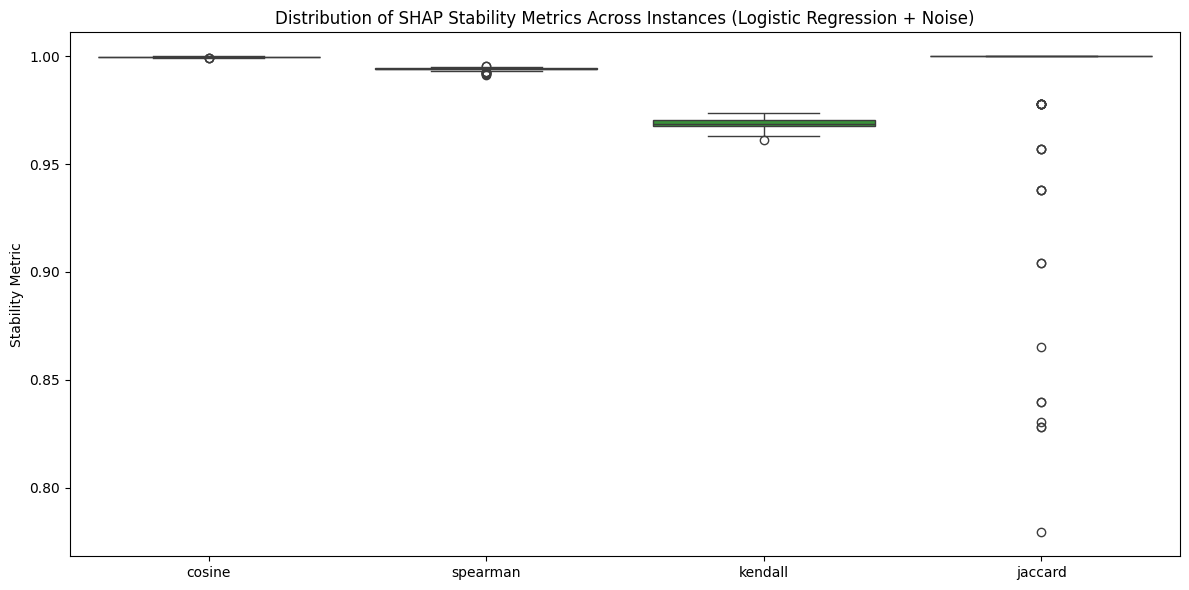

In [54]:
# -------------------------------------
# Parameters
# -------------------------------------
num_instances = len(sample_df)
num_runs = 30       # Repeated SHAP runs per instance
top_k = 5           # Top features for Jaccard similarity
noise_std = 0.01    # Small Gaussian noise (std. dev.)

# -------------------------------------
# Initialize SHAP LinearExplainer
# -------------------------------------
shap_explainer = shap.LinearExplainer(logReg_model, X_train_df)

# -------------------------------------
# Helper: Jaccard similarity
# -------------------------------------
def jaccard_similarity(list1, list2):
    return len(set(list1) & set(list2)) / len(set(list1) | set(list2))

# -------------------------------------
# Helper: Compute stability metrics
# -------------------------------------
def compute_stability(df_expl):
    cosine_matrix = pairwise.cosine_similarity(df_expl)
    mean_cosine = np.mean(cosine_matrix[np.triu_indices_from(cosine_matrix, 1)])

    spearman_corrs, kendall_corrs = [], []
    df_filtered = df_expl.loc[df_expl.var(axis=1) > 1e-9]

    if df_filtered.shape[0] > 1:
        for i in range(df_filtered.shape[0]):
            for j in range(i + 1, df_filtered.shape[0]):
                s, _ = spearmanr(df_filtered.iloc[i], df_filtered.iloc[j])
                k, _ = kendalltau(df_filtered.iloc[i], df_filtered.iloc[j])
                spearman_corrs.append(s)
                kendall_corrs.append(k)
        mean_spearman = np.nanmean(spearman_corrs)
        mean_kendall = np.nanmean(kendall_corrs)
    else:
        mean_spearman = np.nan
        mean_kendall = np.nan

    top_features = [list(df_expl.iloc[i].abs().nlargest(top_k).index) for i in range(df_expl.shape[0])]
    jaccards = [
        jaccard_similarity(top_features[i], top_features[j])
        for i in range(len(top_features)) for j in range(i + 1, len(top_features))
    ]
    mean_jaccard = np.mean(jaccards)

    return mean_cosine, mean_spearman, mean_kendall, mean_jaccard

# -------------------------------------
# SHAP Stability Loop with Noise
# -------------------------------------
shap_stability_results = []

for instance_id in range(num_instances):
    shap_explanations = []

    for i in range(num_runs):
        np.random.seed(i)  # Ensure reproducibility
        base_instance = X_test_df.iloc[[instance_id]].copy()
        noise = np.random.normal(0, noise_std, base_instance.shape)
        noisy_instance = base_instance + noise

        # SHAP on noisy instance
        shap_values = shap_explainer(noisy_instance)
        shap_vector = shap_values.values[0]  # 1D SHAP vector
        shap_expl = dict(zip(X_test_df.columns, shap_vector))
        shap_explanations.append(shap_expl)

    df_shap = pd.DataFrame(shap_explanations).fillna(0)

    # Compute stability metrics
    cos, sp, kt, jac = compute_stability(df_shap)

    shap_stability_results.append({
        "instance_id": instance_id,
        "true_label": sample_df['true_label'].iloc[instance_id],
        "pred_label": sample_df['predicted_label'].iloc[instance_id],
        "pred_prob": sample_df['predicted_prob'].iloc[instance_id],
        "cosine": cos,
        "spearman": sp,
        "kendall": kt,
        "jaccard": jac
    })

# -------------------------------------
# Create DataFrame & Summary
# -------------------------------------
shap_df = pd.DataFrame(shap_stability_results)

print("\n🔹 SHAP Stability Summary Across All Instances (with noise)")
print(shap_df.describe()[["cosine", "spearman", "kendall", "jaccard"]])

# -------------------------------------
# Visualize Stability Distributions
# -------------------------------------
plt.figure(figsize=(12, 6))
sns.boxplot(data=shap_df[["cosine", "spearman", "kendall", "jaccard"]])
plt.title("Distribution of SHAP Stability Metrics Across Instances (Logistic Regression + Noise)")
plt.ylabel("Stability Metric")
plt.tight_layout()
plt.show()


_

_

# **D. SHAP STABILITY IN XGBOOST**

## **1. Local Stability - Loop across 100 samples, 30 runs per sample**

In [88]:
# -------------------------------------
# Parameters
# -------------------------------------
num_runs = 30
top_k = 5  # for Jaccard

# Initialize SHAP TreeExplainer
shap_explainer = shap.TreeExplainer(XG_model)

# Function for Jaccard similarity
def jaccard_similarity(list1, list2):
    return len(set(list1) & set(list2)) / len(set(list1) | set(list2))

# -------------------------------------
# Run across all 100 instances
# -------------------------------------
shap_xgb_stability_results = []

for instance_id in range(len(sample_df1)):
    instance_features = X_test_df.iloc[instance_id:instance_id+1]  # single instance as DataFrame
    shap_explanations = []

    for i in range(num_runs):
        np.random.seed(i)  # for reproducibility
        shap_values = shap_explainer(instance_features)
        shap_vector = shap_values.values[0]  # 1D array of SHAP values
        shap_dict = dict(zip(X_test_df.columns, shap_vector))
        shap_explanations.append(shap_dict)

    df_expl = pd.DataFrame(shap_explanations).fillna(0)

    # Cosine similarity
    cosine_matrix = cosine_similarity(df_expl.values.astype(float))
    mean_cosine = np.mean(cosine_matrix[np.triu_indices_from(cosine_matrix, 1)])

    # Spearman and Kendall
    spearman_corrs, kendall_corrs = [], []
    df_filtered = df_expl.loc[df_expl.var(axis=1) > 1e-9]

    if df_filtered.shape[0] > 1:
        for i in range(df_filtered.shape[0]):
            for j in range(i + 1, df_filtered.shape[0]):
                s, _ = spearmanr(df_filtered.iloc[i], df_filtered.iloc[j])
                k, _ = kendalltau(df_filtered.iloc[i], df_filtered.iloc[j])
                spearman_corrs.append(s)
                kendall_corrs.append(k)

        mean_spearman = np.nanmean(spearman_corrs)
        mean_kendall = np.nanmean(kendall_corrs)
    else:
        mean_spearman = mean_kendall = np.nan

    # Jaccard (Top K)
    top_features = [list(df_expl.iloc[i].abs().nlargest(top_k).index) for i in range(num_runs)]
    jaccards = [
        jaccard_similarity(top_features[i], top_features[j])
        for i in range(num_runs)
        for j in range(i + 1, num_runs)
    ]
    mean_jaccard = np.mean(jaccards)

    # Save metrics
    shap_xgb_stability_results.append({
        "instance_id": instance_id,
        "true_label": sample_df1['true_y_sample'].iloc[instance_id],
        "predicted_label": sample_df1['xg_predicted_label'].iloc[instance_id],
        "predicted_prob": sample_df1['xg_predicted_prob'].iloc[instance_id],
        "cosine": mean_cosine,
        "spearman": mean_spearman,
        "kendall": mean_kendall,
        "jaccard": mean_jaccard
    })

# -------------------------------------
# Summary DataFrame
# -------------------------------------
shap_xgb_stability_df = pd.DataFrame(shap_xgb_stability_results)

# Print summary statistics
print("\n🔹 SHAP TreeExplainer Stability Across 100 Instances (XGBoost)")
print(shap_xgb_stability_df.describe()[["cosine", "spearman", "kendall", "jaccard"]])



🔹 SHAP TreeExplainer Stability Across 100 Instances (XGBoost)
             cosine  spearman  kendall  jaccard
count  1.000000e+02     100.0    100.0    100.0
mean   1.000000e+00       1.0      1.0      1.0
std    1.806106e-16       0.0      0.0      0.0
min    1.000000e+00       1.0      1.0      1.0
25%    1.000000e+00       1.0      1.0      1.0
50%    1.000000e+00       1.0      1.0      1.0
75%    1.000000e+00       1.0      1.0      1.0
max    1.000000e+00       1.0      1.0      1.0


In [94]:
shap_xgb_stability_df

,instance_id,true_label,predicted_label,predicted_prob,cosine,spearman,kendall,jaccard
0,0,1,1,0.619614,1.0,1.0,1.0,1.0
1,1,1,1,0.545894,1.0,1.0,1.0,1.0
2,2,1,1,0.590017,1.0,1.0,1.0,1.0
3,3,1,1,0.802422,1.0,1.0,1.0,1.0
4,4,1,1,0.840350,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...
95,95,0,0,0.172389,1.0,1.0,1.0,1.0
96,96,0,0,0.315615,1.0,1.0,1.0,1.0
97,97,0,0,0.233945,1.0,1.0,1.0,1.0
98,98,0,0,0.293441,1.0,1.0,1.0,1.0


/tmp/ipython-input-2005161495.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, instance_features, feature_names=X_test_df.columns)


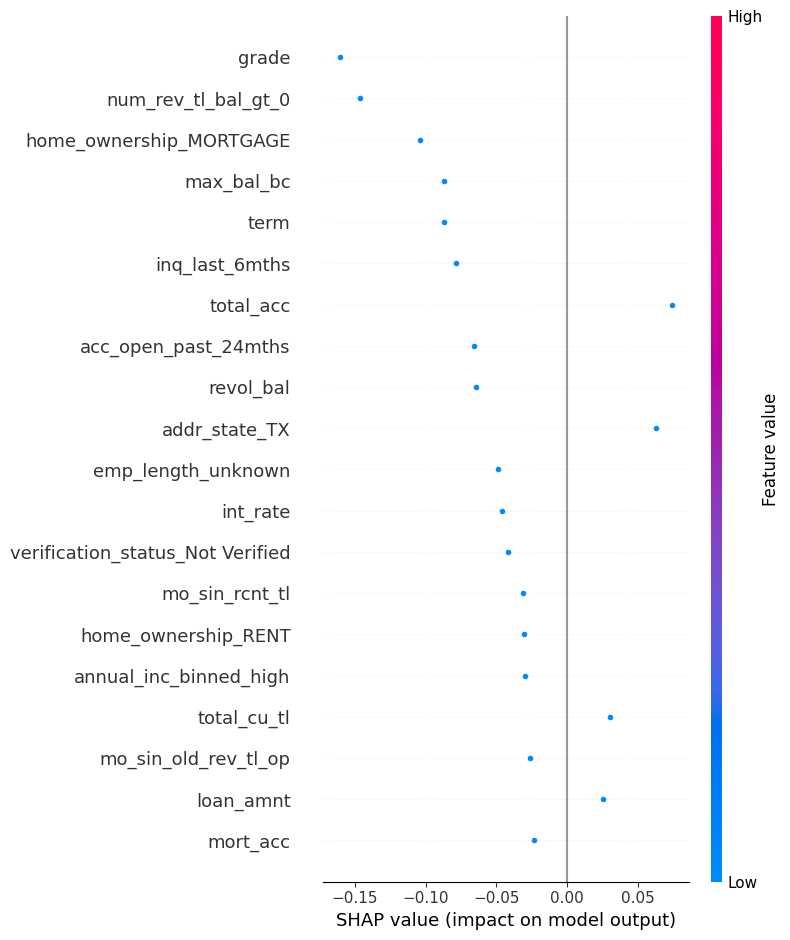

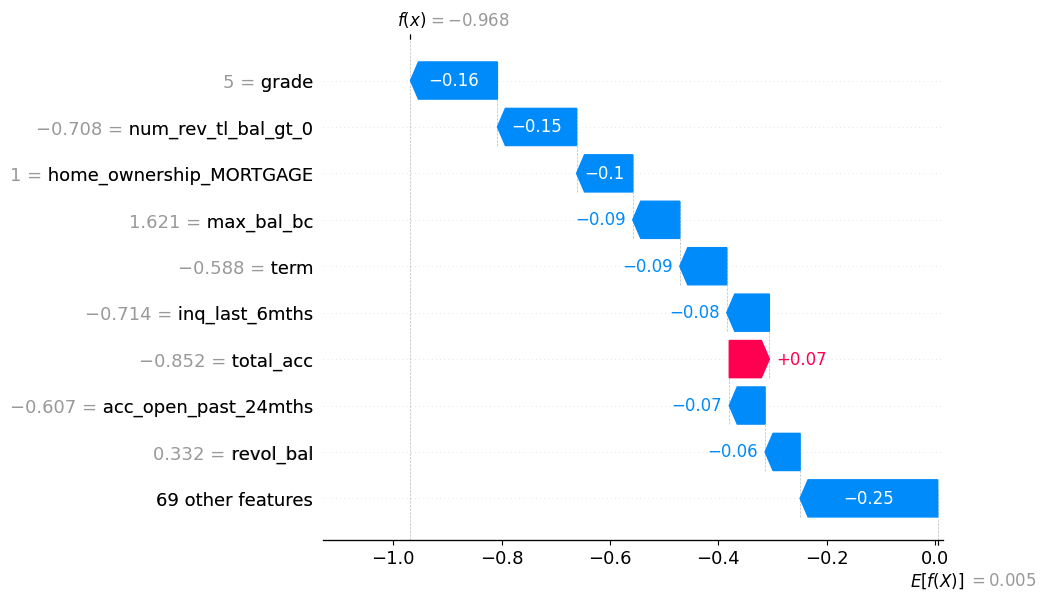

In [97]:
# Get the first instance's features and explanation
instance_id = 0  # First instance
instance_features = X_test_df.iloc[instance_id:instance_id+1]  # Select the first instance

shap_values = shap_explainer(instance_features)

shap.summary_plot(shap_values.values, instance_features, feature_names=X_test_df.columns)

shap.waterfall_plot(shap_values[0])

_

## **2. Local Stability - Across 100 samples, 30 run times for each sample with gaussian noise, 0.01**

In [96]:
# -------------------------------------
# 1️⃣ Parameters
# -------------------------------------
num_runs = 30
top_k = 5        # for Jaccard
noise_fraction = 0.01  # Gaussian noise fraction based on std dev
num_instances = 100  # Number of instances to loop through

# DataFrame to store all results
all_results = []

# -------------------------------------
# 2️⃣ Initialize SHAP TreeExplainer
# -------------------------------------
shap_explainer = shap.TreeExplainer(XG_model)

# -------------------------------------
# 3️⃣ Loop over each instance (up to 100)
# -------------------------------------
for instance_id in range(num_instances):
    # Select instance
    instance_features = X_test_df.iloc[instance_id:instance_id+1].copy()  # single instance as DataFrame

    # Calculate noise level per feature: 1% of feature std dev (from training data)
    feature_stds = X_train_df.std()

    shap_explanations = []

    for i in range(num_runs):
        np.random.seed(i)
        noisy_instance = instance_features.copy()

        # Add Gaussian noise scaled by feature std dev and noise_fraction
        noise = np.random.normal(0, feature_stds * noise_fraction, size=noisy_instance.shape)
        noisy_instance += noise

        # Ensure feature columns stay consistent and no unintended type changes
        noisy_instance = pd.DataFrame(noisy_instance, columns=instance_features.columns)

        shap_values = shap_explainer(noisy_instance)

        # Extract SHAP values for the instance
        shap_vector = shap_values.values[0]  # 1D: one SHAP value per feature
        shap_dict = dict(zip(X_test_df.columns, shap_vector))
        shap_explanations.append(shap_dict)

    # Convert to DataFrame
    df1_expl = pd.DataFrame(shap_explanations).fillna(0)

    # -------------------------------------
    # 4️⃣ Compute Stability Metrics
    # -------------------------------------

    # (a) Cosine similarity
    cosine_matrix = cosine_similarity(df1_expl.values.astype(float))
    mean_cosine_stability = np.mean(cosine_matrix[np.triu_indices_from(cosine_matrix, 1)])

    # (b) Spearman & Kendall correlations
    spearman_corrs, kendall_corrs = [], []
    df1_expl_filtered = df1_expl.loc[df1_expl.var(axis=1) > 1e-9]

    if df1_expl_filtered.shape[0] > 1:
        for i in range(df1_expl_filtered.shape[0]):
            for j in range(i + 1, df1_expl_filtered.shape[0]):
                s, _ = spearmanr(df1_expl_filtered.iloc[i], df1_expl_filtered.iloc[j])
                k, _ = kendalltau(df1_expl_filtered.iloc[i], df1_expl_filtered.iloc[j])
                spearman_corrs.append(s)
                kendall_corrs.append(k)

        mean_spearman = np.nanmean(spearman_corrs)
        mean_kendall = np.nanmean(kendall_corrs)
    else:
        mean_spearman = mean_kendall = np.nan

    # (c) Jaccard similarity (Top k features)
    def jaccard_similarity(list1, list2):
        return len(set(list1) & set(list2)) / len(set(list1) | set(list2))

    top_features = [list(df1_expl.iloc[i].abs().nlargest(top_k).index) for i in range(num_runs)]
    jaccards = [
        jaccard_similarity(top_features[i], top_features[j])
        for i in range(num_runs)
        for j in range(i + 1, num_runs)
    ]
    mean_jaccard = np.mean(jaccards)

    # -------------------------------------
    # 5️⃣ Save Results to DataFrame
    # -------------------------------------
    # Prepare instance-level data for final DataFrame
    instance_results = {
        'instance_id': instance_id,
        'true_label': sample_df1['true_y_sample'].iloc[instance_id],
        'predicted_label': sample_df1['xg_predicted_label'].iloc[instance_id],
        'predicted_prob': sample_df1['xg_predicted_prob'].iloc[instance_id],
        'mean_cosine_stability': mean_cosine_stability,
        'mean_spearman': mean_spearman,
        'mean_kendall': mean_kendall,
        'mean_jaccard': mean_jaccard
    }

    # Add SHAP values to instance-level data (averaged across all runs)
    shap_avg = df1_expl.mean(axis=0).to_dict()
    instance_results.update(shap_avg)

    # Append the result for this instance to all_results
    all_results.append(instance_results)

# Convert all_results list to DataFrame
shap_noise_xgb = pd.DataFrame(all_results)

# Print summary statistics for the stability metrics
print("\n🔹 SHAP TreeExplainer Stability Across 100 Instances (XGBoost)")
print(shap_noise_xgb.describe()[["mean_cosine_stability", "mean_spearman", "mean_kendall", "mean_jaccard"]])



🔹 SHAP TreeExplainer Stability Across 100 Instances (XGBoost)
       mean_cosine_stability  mean_spearman  mean_kendall  mean_jaccard
count             100.000000     100.000000    100.000000    100.000000
mean                0.882736       0.799922      0.767587      0.695238
std                 0.090435       0.038015      0.033270      0.138468
min                 0.552070       0.687452      0.672247      0.388077
25%                 0.842222       0.776515      0.745716      0.611624
50%                 0.912782       0.797596      0.766940      0.680870
75%                 0.945108       0.828060      0.790629      0.782895
max                 0.983929       0.890443      0.836969      1.000000


In [98]:
shap_noise_xgb

,instance_id,true_label,predicted_label,predicted_prob,mean_cosine_stability,mean_spearman,mean_kendall,mean_jaccard,emp_length_1 year,emp_length_10+ years,...,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_accts_ever_120_pd,num_bc_tl,num_rev_tl_bal_gt_0,pub_rec_bankruptcies,mo_sin_old_il_acct_missing,high_dti_risk
0,0,1,1,0.619614,0.769079,0.770940,0.736863,0.540622,-0.001504,0.010841,...,-0.019585,0.013810,-0.019287,0.031253,-0.006602,-0.009288,-0.148507,-0.000075,0.0,0.0
1,1,1,1,0.545894,0.968302,0.800946,0.779488,0.746470,-0.003362,-0.005654,...,-0.027160,-0.017106,-0.025613,0.098983,-0.008276,-0.010578,-0.127315,-0.001325,0.0,0.0
2,2,1,1,0.590017,0.972878,0.780812,0.734886,0.798467,0.029340,0.009787,...,0.185224,0.000156,0.023340,0.041534,-0.017518,-0.002181,-0.145465,-0.004050,0.0,0.0
3,3,1,1,0.802422,0.724743,0.772277,0.759594,0.679037,-0.004973,-0.009770,...,-0.043793,-0.044559,-0.012581,-0.151854,-0.007751,-0.006811,-0.078066,-0.001075,0.0,0.0
4,4,1,1,0.840350,0.934808,0.782929,0.746685,0.659661,0.016480,0.008494,...,0.078317,-0.005631,-0.022303,0.126148,-0.015185,-0.011904,-0.158581,0.002178,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0,0,0.172389,0.884613,0.759400,0.728391,0.753804,-0.002402,0.010276,...,-0.044987,0.074135,0.052158,0.027128,0.009237,0.007768,0.120594,0.001848,0.0,0.0
96,96,0,0,0.315615,0.892647,0.816273,0.779669,0.833169,-0.003693,0.011109,...,0.025863,0.023287,0.063408,0.091760,-0.007981,-0.004804,-0.078988,-0.002239,0.0,0.0
97,97,0,0,0.233945,0.903933,0.795383,0.767485,0.525342,-0.003122,0.008381,...,0.107718,0.004801,0.014440,0.089268,-0.002547,-0.012452,-0.096472,0.006062,0.0,0.0
98,98,0,0,0.293441,0.785479,0.807081,0.763880,0.454953,-0.003909,0.012577,...,-0.023247,0.010846,-0.016125,0.032209,-0.005989,-0.000451,-0.092940,-0.010363,0.0,0.0


/tmp/ipython-input-2683461668.py:21: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values.values, noisy_instance, feature_names=X_test_df.columns)


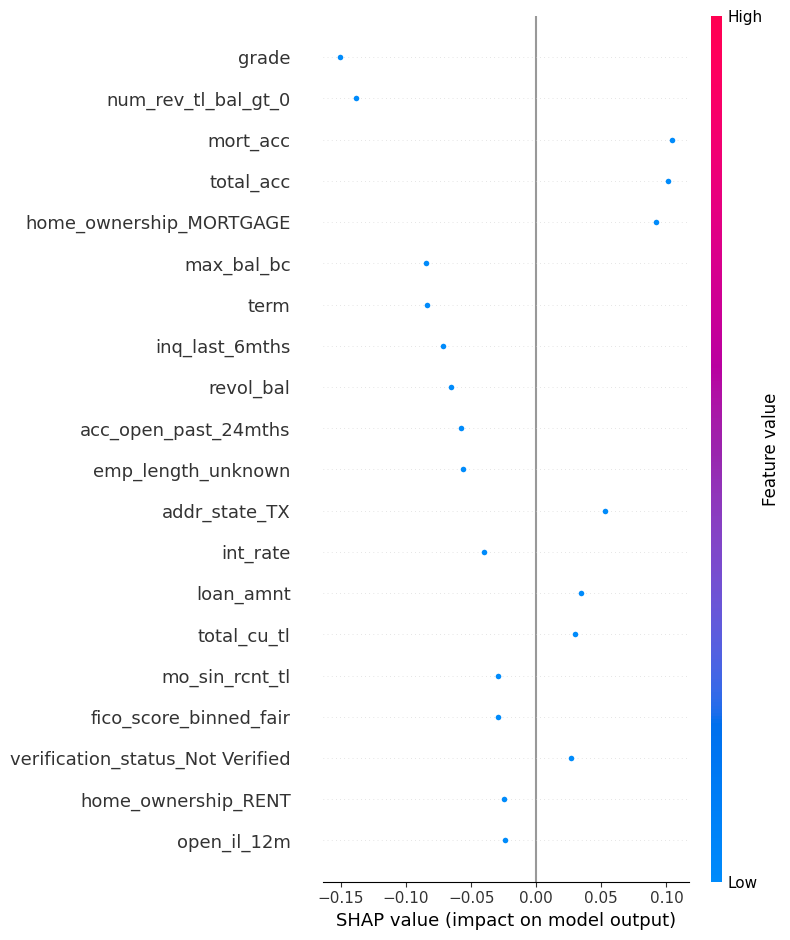

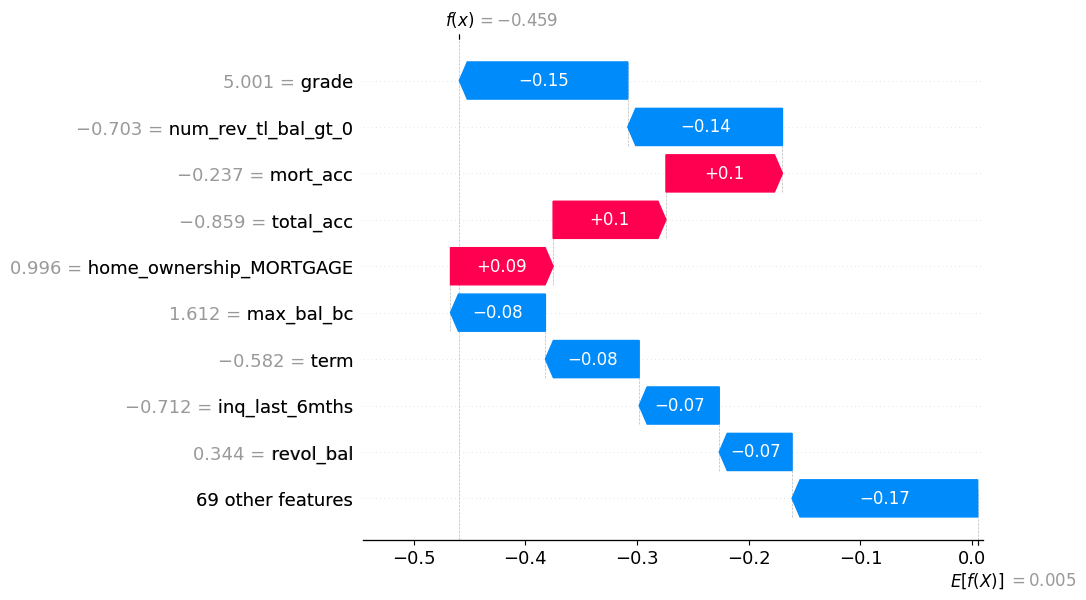

In [99]:
# Select the first instance for visualization (instance_id = 0)
instance_id = 0  # You can change this to any instance ID

# Extract the features for this instance
instance_features = X_test_df.iloc[instance_id:instance_id+1].copy()

# Add Gaussian noise as in the main loop
feature_stds = X_train_df.std()
noise = np.random.normal(0, feature_stds * noise_fraction, size=instance_features.shape)
noisy_instance = instance_features + noise

# Ensure feature columns stay consistent
noisy_instance = pd.DataFrame(noisy_instance, columns=instance_features.columns)

# Generate SHAP values for the noisy instance
shap_values = shap_explainer(noisy_instance)

# -------------------------------------
# 1️⃣ SHAP Summary Plot
# -------------------------------------
shap.summary_plot(shap_values.values, noisy_instance, feature_names=X_test_df.columns)

# -------------------------------------
# 2️⃣ SHAP Waterfall Plot
# -------------------------------------
shap.waterfall_plot(shap_values[0])

_

## **3. Global Stability**


🔹 Global SHAP Stability Summary for XGBoost Model
             cosine  spearman  kendall  jaccard
count  1.000000e+02     100.0    100.0    100.0
mean   1.000000e+00       1.0      1.0      1.0
std    1.373901e-07       0.0      0.0      0.0
min    9.999993e-01       1.0      1.0      1.0
25%    9.999999e-01       1.0      1.0      1.0
50%    1.000000e+00       1.0      1.0      1.0
75%    1.000000e+00       1.0      1.0      1.0
max    1.000001e+00       1.0      1.0      1.0


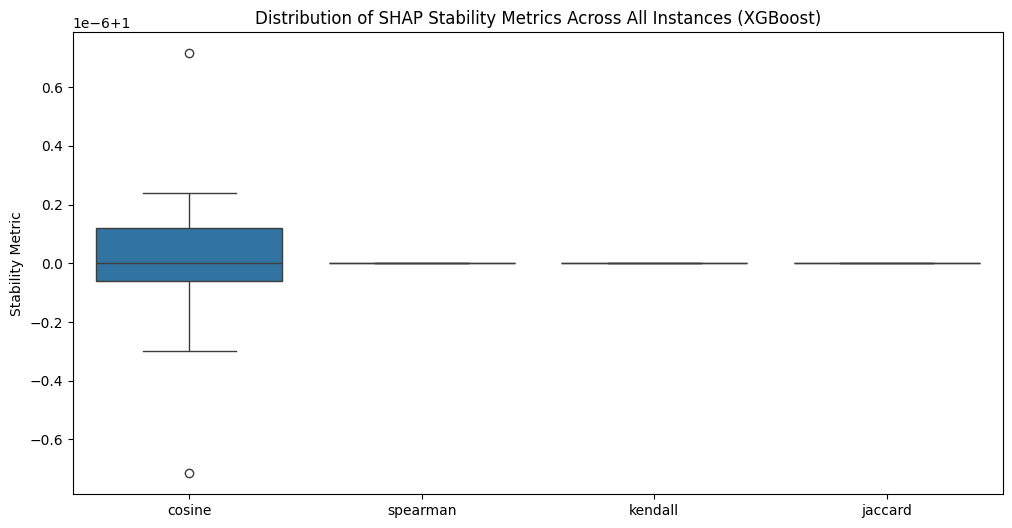

In [46]:
# -------------------------------------
# Parameters
# -------------------------------------
num_instances = len(sample_df1)
num_runs = 30
top_k = 5  # Top features for Jaccard

# -------------------------------------
# Initialize TreeSHAP Explainer for XGBoost
# -------------------------------------
shap_explainer = shap.TreeExplainer(XG_model)

# -------------------------------------
# Helper function: Jaccard similarity
# -------------------------------------
def jaccard_similarity(list1, list2):
    return len(set(list1) & set(list2)) / len(set(list1) | set(list2))

# -------------------------------------
# Storage for stability results
# -------------------------------------
stability_results = []

# -------------------------------------
# Loop over all instances
# -------------------------------------
for instance_id in range(num_instances):
    instance_features = sample_df1[X_train_df.columns].iloc[[instance_id]]

    shap_explanations = []
    for i in range(num_runs):
        np.random.seed(i)
        shap_values = shap_explainer(instance_features)  # returns shap.Explanation object
        shap_vector = shap_values.values[0]  # shape: (num_features,)
        shap_dict = dict(zip(X_train_df.columns, shap_vector))
        shap_explanations.append(shap_dict)


    # Convert to DataFrame
    df_expl = pd.DataFrame(shap_explanations).fillna(0)

    # Cosine similarity
    cosine_matrix = pairwise.cosine_similarity(df_expl)
    mean_cosine = np.mean(cosine_matrix[np.triu_indices_from(cosine_matrix, 1)])

    # Spearman & Kendall
    spearman_corrs, kendall_corrs = [], []
    df_filtered = df_expl.loc[df_expl.var(axis=1) > 1e-9]
    if df_filtered.shape[0] > 1:
        for i in range(df_filtered.shape[0]):
            for j in range(i + 1, df_filtered.shape[0]):
                s, _ = spearmanr(df_filtered.iloc[i], df_filtered.iloc[j])
                k, _ = kendalltau(df_filtered.iloc[i], df_filtered.iloc[j])
                spearman_corrs.append(s)
                kendall_corrs.append(k)
        mean_spearman = np.nanmean(spearman_corrs)
        mean_kendall = np.nanmean(kendall_corrs)
    else:
        mean_spearman = mean_kendall = np.nan

    # Jaccard similarity (Top-k)
    top_features = [list(df_expl.iloc[i].abs().nlargest(top_k).index) for i in range(num_runs)]
    jaccards = [
        jaccard_similarity(top_features[i], top_features[j])
        for i in range(num_runs) for j in range(i + 1, num_runs)
    ]
    mean_jaccard = np.mean(jaccards)

    # Store results
    stability_results.append({
        "instance_id": instance_id,
        "true_label": sample_df1['true_y_sample'].iloc[instance_id],
        "pred_label": sample_df1['xg_predicted_label'].iloc[instance_id],
        "pred_prob": sample_df1['xg_predicted_prob'].iloc[instance_id],
        "cosine": mean_cosine,
        "spearman": mean_spearman,
        "kendall": mean_kendall,
        "jaccard": mean_jaccard
    })

# -------------------------------------
# Summary Table
# -------------------------------------
stability_df = pd.DataFrame(stability_results)

print("\n🔹 Global SHAP Stability Summary for XGBoost Model")
print(stability_df.describe()[["cosine", "spearman", "kendall", "jaccard"]])

# -------------------------------------
# Visualization
# -------------------------------------
plt.figure(figsize=(12, 6))
sns.boxplot(data=stability_df[["cosine", "spearman", "kendall", "jaccard"]])
plt.title("Distribution of SHAP Stability Metrics Across All Instances (XGBoost)")
plt.ylabel("Stability Metric")
plt.show()


_

## **4. Global Stability with 0.01 Gaussian noise**


🔹 SHAP Stability Summary with Noise (XGBoost)
           cosine    spearman     kendall     jaccard
count  100.000000  100.000000  100.000000  100.000000
mean     0.881821    0.803352    0.771195    0.708302
std      0.093950    0.044991    0.038913    0.139488
min      0.557781    0.703361    0.686593    0.454972
25%      0.847268    0.776709    0.740513    0.612828
50%      0.906036    0.806479    0.776918    0.705542
75%      0.950833    0.837301    0.799111    0.801122
max      0.992175    0.894220    0.849520    1.000000


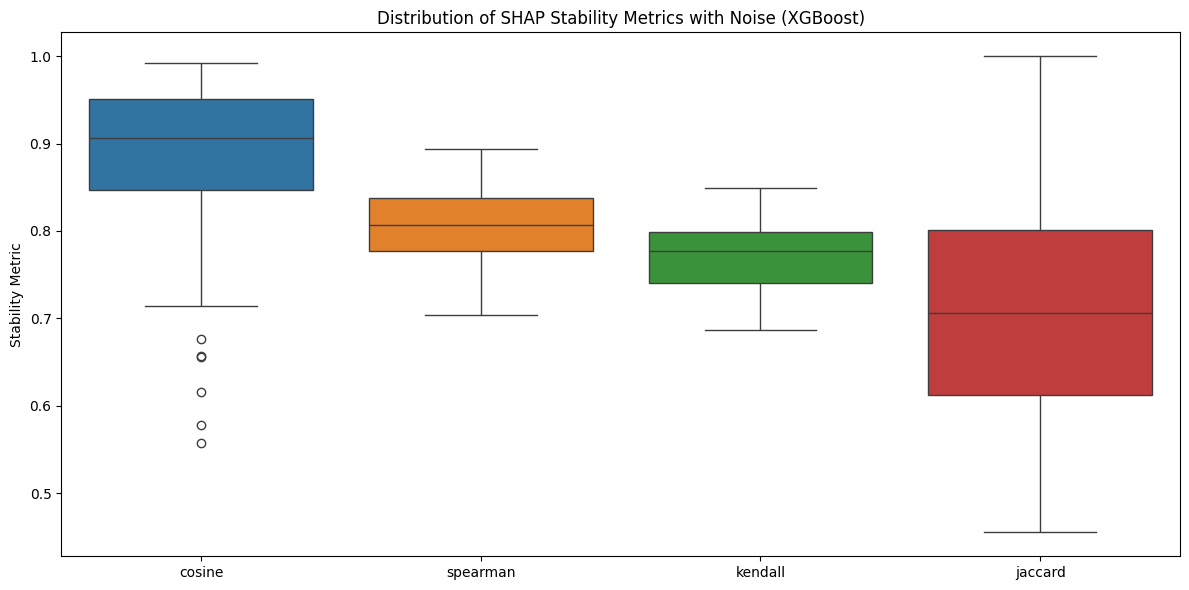

In [51]:
# -------------------------------------
# Parameters
# -------------------------------------
num_instances = len(sample_df1)
num_runs = 30
top_k = 5
noise_std = 0.01  # Recommended small noise (from literature like Slack et al., 2020)

# -------------------------------------
# Initialize SHAP TreeExplainer
# -------------------------------------
shap_explainer = shap.TreeExplainer(XG_model)

# -------------------------------------
# Jaccard Similarity
# -------------------------------------
def jaccard_similarity(list1, list2):
    return len(set(list1) & set(list2)) / len(set(list1) | set(list2))

# -------------------------------------
# Loop over all instances
# -------------------------------------
stability_results = []

for instance_id in range(num_instances):
    instance_features = sample_df1[X_train_df.columns].iloc[[instance_id]]

    shap_explanations = []
    for i in range(num_runs):
        np.random.seed(i)
        noisy_instance = instance_features + np.random.normal(0, noise_std, instance_features.shape)
        shap_values = shap_explainer(noisy_instance)
        shap_vector = shap_values.values[0]
        shap_dict = dict(zip(X_train_df.columns, shap_vector))
        shap_explanations.append(shap_dict)

    df_expl = pd.DataFrame(shap_explanations).fillna(0)

    cosine_matrix = cosine_similarity(df_expl)
    mean_cosine = np.mean(cosine_matrix[np.triu_indices_from(cosine_matrix, 1)])

    spearman_corrs, kendall_corrs = [], []
    df_filtered = df_expl.loc[df_expl.var(axis=1) > 1e-9]
    if df_filtered.shape[0] > 1:
        for i in range(df_filtered.shape[0]):
            for j in range(i + 1, df_filtered.shape[0]):
                s, _ = spearmanr(df_filtered.iloc[i], df_filtered.iloc[j])
                k, _ = kendalltau(df_filtered.iloc[i], df_filtered.iloc[j])
                spearman_corrs.append(s)
                kendall_corrs.append(k)
        mean_spearman = np.nanmean(spearman_corrs)
        mean_kendall = np.nanmean(kendall_corrs)
    else:
        mean_spearman = mean_kendall = np.nan

    top_features = [list(df_expl.iloc[i].abs().nlargest(top_k).index) for i in range(num_runs)]
    jaccards = [
        jaccard_similarity(top_features[i], top_features[j])
        for i in range(num_runs)
        for j in range(i + 1, num_runs)
    ]
    mean_jaccard = np.mean(jaccards)

    stability_results.append({
        "instance_id": instance_id,
        "true_label": sample_df1['true_y_sample'].iloc[instance_id],
        "pred_label": sample_df1['xg_predicted_label'].iloc[instance_id],
        "pred_prob": sample_df1['xg_predicted_prob'].iloc[instance_id],
        "cosine": mean_cosine,
        "spearman": mean_spearman,
        "kendall": mean_kendall,
        "jaccard": mean_jaccard
    })

# -------------------------------------
# Results & Visualization
# -------------------------------------
stability_df = pd.DataFrame(stability_results)

print("\n🔹 SHAP Stability Summary with Noise (XGBoost)")
print(stability_df.describe()[["cosine", "spearman", "kendall", "jaccard"]])

plt.figure(figsize=(12, 6))
sns.boxplot(data=stability_df[["cosine", "spearman", "kendall", "jaccard"]])
plt.title("Distribution of SHAP Stability Metrics with Noise (XGBoost)")
plt.ylabel("Stability Metric")
plt.tight_layout()
plt.show()


_

_

_

# **STATISTICAL ANALYSIS OF THE CONSISTENCY AND RELIABILITY OF SHAP AND LIME**

## **1. LIME ANALYSIS**

### **i. Merge data for both models**

In [100]:
lime_stability_df

,instance_id,true_label,predicted_label,predicted_prob,cosine,spearman,kendall,jaccard
0,0,1,1,0.615871,0.940871,0.901269,0.814640,0.841270
1,1,1,1,0.516678,0.950451,0.949735,0.895254,0.815435
2,2,1,1,0.630397,0.934396,0.818608,0.713536,0.777778
3,3,1,1,0.681285,0.970109,0.948565,0.893523,0.821456
4,4,1,1,0.839100,0.977217,0.961914,0.921325,0.889655
...,...,...,...,...,...,...,...,...
95,95,0,0,0.260182,0.942972,0.914870,0.840487,0.809962
96,96,0,0,0.320986,0.930285,0.904170,0.833322,0.723591
97,97,0,0,0.282655,0.962300,0.960341,0.917895,0.797811
98,98,0,0,0.319445,0.943060,0.949928,0.894616,0.805583


In [101]:
lime_stability_xgb

,instance_id,true_label,predicted_label,predicted_prob,cosine,spearman,kendall,jaccard
0,0,1,1,0.619614,0.913689,0.887811,0.821370,0.705528
1,1,1,1,0.545894,0.931904,0.914125,0.841887,0.751943
2,2,1,1,0.590017,0.917895,0.852576,0.778493,0.658976
3,3,1,1,0.802422,0.953152,0.922867,0.850467,0.880569
4,4,1,1,0.840350,0.954296,0.891804,0.828484,0.872031
...,...,...,...,...,...,...,...,...
95,95,0,0,0.172389,0.943723,0.889230,0.830510,0.859332
96,96,0,0,0.315615,0.894423,0.805635,0.735268,0.735441
97,97,0,0,0.233945,0.960235,0.921162,0.871221,0.855939
98,98,0,0,0.293441,0.934762,0.900998,0.837701,0.749206


In [106]:
# Merge the LIME results for both models (XGBoost and Logistic Regression)
lime_local_lrxgb = lime_stability_xgb.merge(lime_stability_df, on="instance_id", suffixes=('_xgb', '_lr'))

display (lime_local_lrxgb)

,instance_id,true_label_xgb,predicted_label_xgb,predicted_prob_xgb,cosine_xgb,spearman_xgb,kendall_xgb,jaccard_xgb,true_label_lr,predicted_label_lr,predicted_prob_lr,cosine_lr,spearman_lr,kendall_lr,jaccard_lr
0,0,1,1,0.619614,0.913689,0.887811,0.821370,0.705528,1,1,0.615871,0.940871,0.901269,0.814640,0.841270
1,1,1,1,0.545894,0.931904,0.914125,0.841887,0.751943,1,1,0.516678,0.950451,0.949735,0.895254,0.815435
2,2,1,1,0.590017,0.917895,0.852576,0.778493,0.658976,1,1,0.630397,0.934396,0.818608,0.713536,0.777778
3,3,1,1,0.802422,0.953152,0.922867,0.850467,0.880569,1,1,0.681285,0.970109,0.948565,0.893523,0.821456
4,4,1,1,0.840350,0.954296,0.891804,0.828484,0.872031,1,1,0.839100,0.977217,0.961914,0.921325,0.889655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0,0,0.172389,0.943723,0.889230,0.830510,0.859332,0,0,0.260182,0.942972,0.914870,0.840487,0.809962
96,96,0,0,0.315615,0.894423,0.805635,0.735268,0.735441,0,0,0.320986,0.930285,0.904170,0.833322,0.723591
97,97,0,0,0.233945,0.960235,0.921162,0.871221,0.855939,0,0,0.282655,0.962300,0.960341,0.917895,0.797811
98,98,0,0,0.293441,0.934762,0.900998,0.837701,0.749206,0,0,0.319445,0.943060,0.949928,0.894616,0.805583


In [113]:
# Drop the specified columns from the DataFrame
lime_local = lime_local_lrxgb.drop(columns=['true_label_xgb', 'predicted_label_xgb', 'true_label_lr', 'predicted_label_lr'])
display (lime_local)

,instance_id,predicted_prob_xgb,cosine_xgb,spearman_xgb,kendall_xgb,jaccard_xgb,predicted_prob_lr,cosine_lr,spearman_lr,kendall_lr,jaccard_lr
0,0,0.619614,0.913689,0.887811,0.821370,0.705528,0.615871,0.940871,0.901269,0.814640,0.841270
1,1,0.545894,0.931904,0.914125,0.841887,0.751943,0.516678,0.950451,0.949735,0.895254,0.815435
2,2,0.590017,0.917895,0.852576,0.778493,0.658976,0.630397,0.934396,0.818608,0.713536,0.777778
3,3,0.802422,0.953152,0.922867,0.850467,0.880569,0.681285,0.970109,0.948565,0.893523,0.821456
4,4,0.840350,0.954296,0.891804,0.828484,0.872031,0.839100,0.977217,0.961914,0.921325,0.889655
...,...,...,...,...,...,...,...,...,...,...,...
95,95,0.172389,0.943723,0.889230,0.830510,0.859332,0.260182,0.942972,0.914870,0.840487,0.809962
96,96,0.315615,0.894423,0.805635,0.735268,0.735441,0.320986,0.930285,0.904170,0.833322,0.723591
97,97,0.233945,0.960235,0.921162,0.871221,0.855939,0.282655,0.962300,0.960341,0.917895,0.797811
98,98,0.293441,0.934762,0.900998,0.837701,0.749206,0.319445,0.943060,0.949928,0.894616,0.805583


_

### **ii. Comparing the stability of LIME explanations between Logistic Regression (LR) and XGBoost (XGB) models across four different metrics**

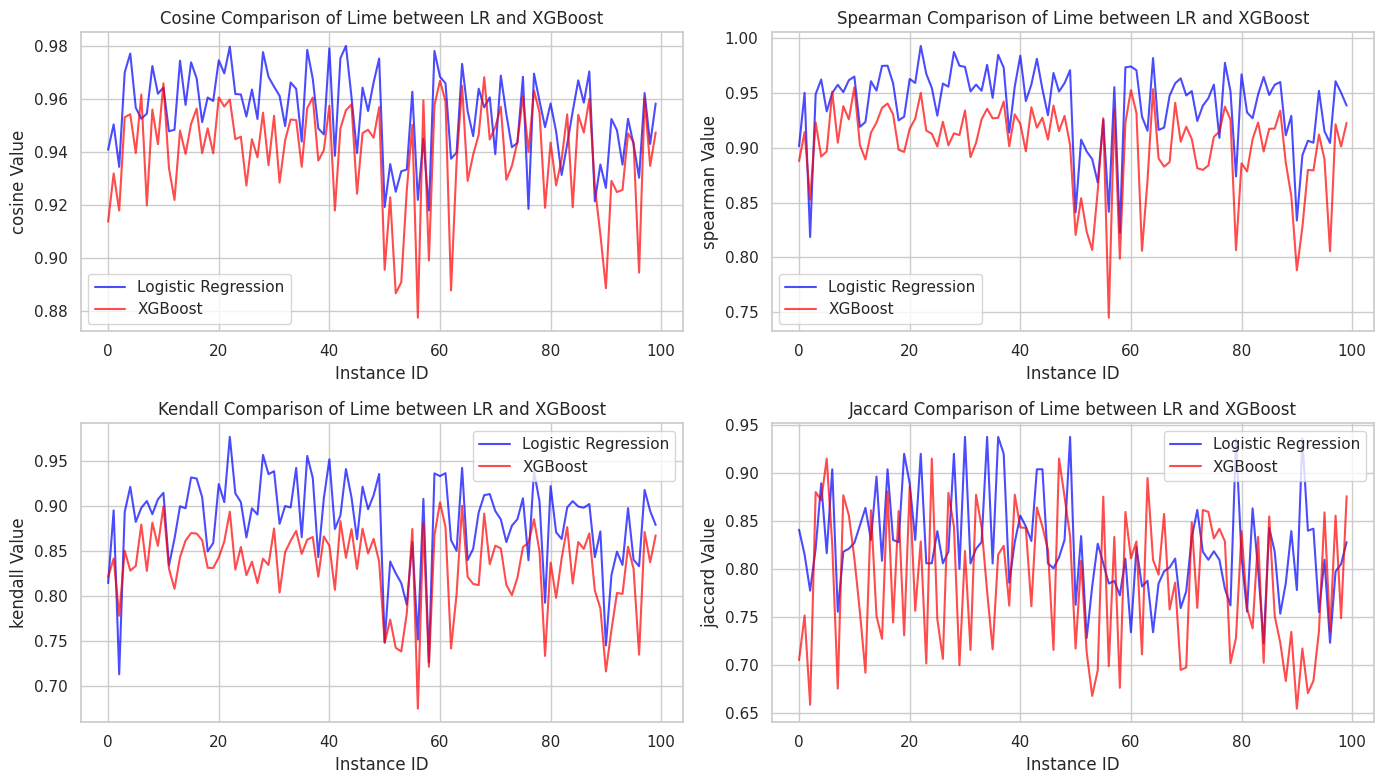

In [138]:
# Set up a seaborn style for better visualization
sns.set(style="whitegrid")

# Define the metrics of interest
metrics = ['cosine', 'spearman', 'kendall', 'jaccard']

# Create a new DataFrame to hold both model results for easy plotting
# Select the columns with the correct suffixes for both models
plot_df = lime_local[['instance_id'] + [metric + '_lr' for metric in metrics] + [metric + '_xgb' for metric in metrics]]

# Set the figure size
plt.figure(figsize=(14, 8))

# Loop through each metric and plot the comparison between the two models
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)  # Create subplots for each metric
    plt.plot(plot_df['instance_id'], plot_df[metric + '_lr'], label='Logistic Regression', color='blue', alpha=0.7)
    plt.plot(plot_df['instance_id'], plot_df[metric + '_xgb'], label='XGBoost', color='red', alpha=0.7)

    plt.xlabel('Instance ID')
    plt.ylabel(f'{metric} Value')
    plt.title(f'{metric.capitalize()} Comparison of Lime between LR and XGBoost')
    plt.legend()


# Adjust layout and show the plot
plt.tight_layout()
plt.show()


_

### **iii. Wilcoxon Test**

In [143]:
# Define a function to perform Wilcoxon Signed Rank Test for each metric
def wilcoxon_test(data_lr, data_xgb, metric_name):
    # Perform the Wilcoxon Signed Rank test
    stat, p_value = wilcoxon(data_lr, data_xgb)

    # Print the results
    print(f"Wilcoxon test for {metric_name}:")
    print(f"Test statistic = {stat:.3f}, p-value = {p_value:.3f}")

    if p_value < 0.05:
        print(f"Result: There is a significant difference in {metric_name} between Logistic Regression and XGBoost.")
    else:
        print(f"Result: No significant difference in {metric_name} between Logistic Regression and XGBoost.")
    print("\n" + "-"*50)

# Perform Wilcoxon Signed Rank Test for each metric
metrics_lr = ['cosine_lr', 'spearman_lr', 'kendall_lr', 'jaccard_lr']
metrics_xgb = ['cosine_xgb', 'spearman_xgb', 'kendall_xgb', 'jaccard_xgb']

# Loop through each metric and run the Wilcoxon test
for lr_metric, xgb_metric in zip(metrics_lr, metrics_xgb):
    wilcoxon_test(lime_local[lr_metric], lime_local[xgb_metric], lr_metric.split('_')[0])


Wilcoxon test for cosine:
Test statistic = 264.000, p-value = 0.000
Result: There is a significant difference in cosine between Logistic Regression and XGBoost.

--------------------------------------------------
Wilcoxon test for spearman:
Test statistic = 50.000, p-value = 0.000
Result: There is a significant difference in spearman between Logistic Regression and XGBoost.

--------------------------------------------------
Wilcoxon test for kendall:
Test statistic = 101.000, p-value = 0.000
Result: There is a significant difference in kendall between Logistic Regression and XGBoost.

--------------------------------------------------
Wilcoxon test for jaccard:
Test statistic = 1300.000, p-value = 0.000
Result: There is a significant difference in jaccard between Logistic Regression and XGBoost.

--------------------------------------------------


_

### **iv. Comparing Lime Explanation Consistency Metrics Across Logistic Regression and XGBoost**

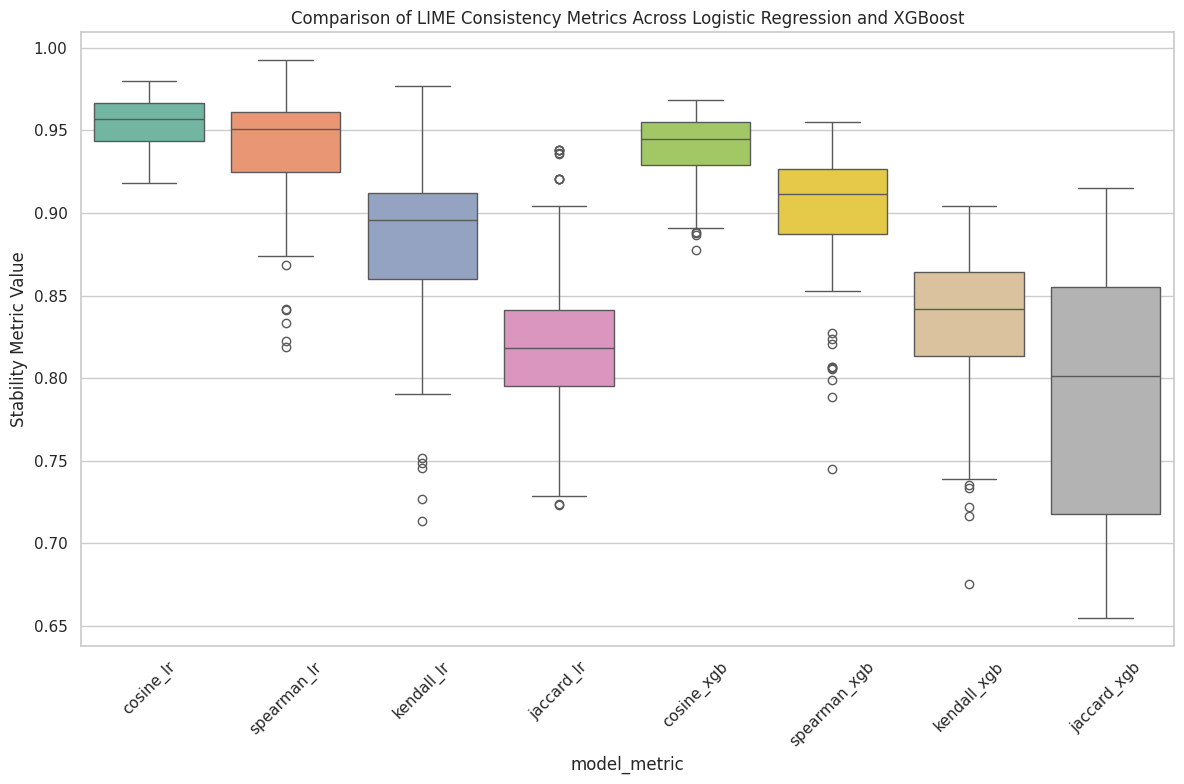

In [144]:
# Create a combined DataFrame for easy plotting
plot_df = lime_local[['instance_id'] + metrics_lr + metrics_xgb]

# Melt the DataFrame for easier plotting with seaborn
plot_df_melted = plot_df.melt(id_vars="instance_id", value_vars=metrics_lr + metrics_xgb,
                               var_name="model_metric", value_name="value")

# Create a boxplot for each metric across models
plt.figure(figsize=(12, 8))
sns.boxplot(data=plot_df_melted, x="model_metric", y="value", hue="model_metric", palette="Set2")
plt.title("Comparison of LIME Consistency Metrics Across Logistic Regression and XGBoost")
plt.ylabel("Stability Metric Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


_

### **v. Summary Statistics of Metrices**

In [145]:
# Calculate summary statistics for both models
lime_summary = lime_local[['cosine_lr', 'cosine_xgb', 'spearman_lr', 'spearman_xgb', 'kendall_lr', 'kendall_xgb', 'jaccard_lr', 'jaccard_xgb']].describe()

# Print summary statistics
display(lime_summary)


,cosine_lr,cosine_xgb,spearman_lr,spearman_xgb,kendall_lr,kendall_xgb,jaccard_lr,jaccard_xgb
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.954608,0.939594,0.939899,0.900538,0.882613,0.833460,0.824352,0.787784
std,0.015757,0.020020,0.035689,0.040057,0.050249,0.044624,0.052139,0.072692
min,0.917919,0.877408,0.818608,0.745263,0.713536,0.675387,0.723153,0.654926
25%,0.943352,0.928925,0.924611,0.887572,0.859865,0.813432,0.795402,0.717570
50%,0.956805,0.944579,0.951065,0.911609,0.895903,0.842013,0.818391,0.801628
75%,0.966510,0.954872,0.961427,0.926428,0.912414,0.864193,0.841544,0.855364
max,0.980098,0.968264,0.992494,0.954883,0.976693,0.904171,0.937931,0.915380


_

### **vi. Correlation of metrices**

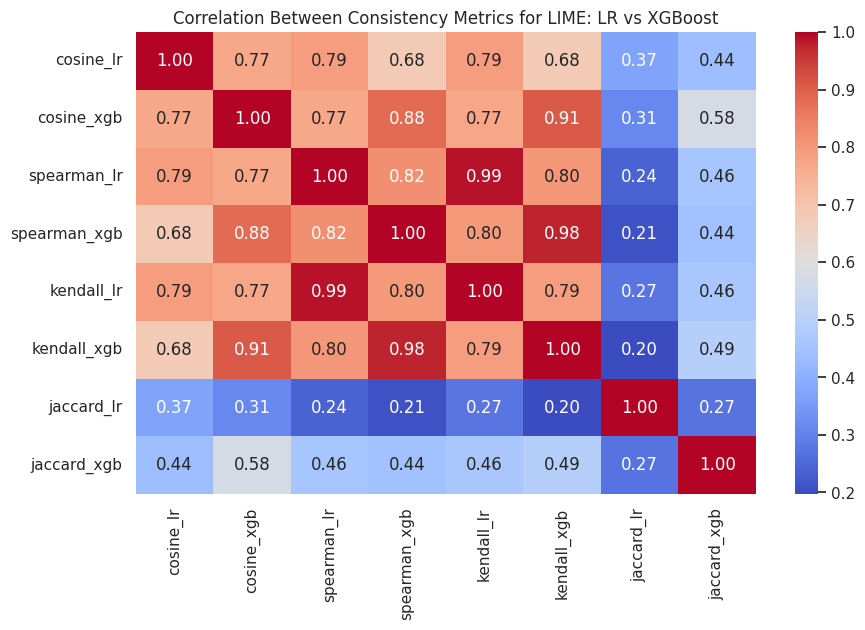

In [146]:
# Calculate correlation between consistency metrics of LR and XGBoost
correlation_matrix = lime_local[['cosine_lr', 'cosine_xgb', 'spearman_lr', 'spearman_xgb', 'kendall_lr', 'kendall_xgb', 'jaccard_lr', 'jaccard_xgb']].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Consistency Metrics for LIME: LR vs XGBoost')
plt.show()


_

_

## **2. SHAP ANALYSIS**

### **i. Merge data**

In [124]:
shap_noise_stability_lr

,instance_id,true_label,predicted_label,predicted_prob,cosine,spearman,kendall,jaccard
0,0,1,1,0.615871,0.999553,0.994027,0.968930,0.956322
1,1,1,1,0.516678,0.999467,0.994333,0.968435,0.977778
2,2,1,1,0.630397,0.999811,0.994323,0.968884,1.000000
3,3,1,1,0.681285,0.999824,0.995366,0.974196,1.000000
4,4,1,1,0.839100,0.999909,0.994247,0.969940,1.000000
...,...,...,...,...,...,...,...,...
95,95,0,0,0.260182,0.999652,0.994593,0.971071,1.000000
96,96,0,0,0.320986,0.999403,0.994274,0.967407,0.834483
97,97,0,0,0.282655,0.999852,0.994378,0.969848,1.000000
98,98,0,0,0.319445,0.999706,0.994466,0.970336,0.977778


In [129]:
# Drop the specified columns from the DataFrame
shap_nlr = shap_noise_stability_lr.drop(columns=['true_label', 'predicted_label', 'predicted_prob'])
display (shap_nlr)

,instance_id,cosine,spearman,kendall,jaccard
0,0,0.999553,0.994027,0.968930,0.956322
1,1,0.999467,0.994333,0.968435,0.977778
2,2,0.999811,0.994323,0.968884,1.000000
3,3,0.999824,0.995366,0.974196,1.000000
4,4,0.999909,0.994247,0.969940,1.000000
...,...,...,...,...,...
95,95,0.999652,0.994593,0.971071,1.000000
96,96,0.999403,0.994274,0.967407,0.834483
97,97,0.999852,0.994378,0.969848,1.000000
98,98,0.999706,0.994466,0.970336,0.977778


In [122]:
shap_noise_xgb

,instance_id,true_label,predicted_label,predicted_prob,mean_cosine_stability,mean_spearman,mean_kendall,mean_jaccard,emp_length_1 year,emp_length_10+ years,...,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_accts_ever_120_pd,num_bc_tl,num_rev_tl_bal_gt_0,pub_rec_bankruptcies,mo_sin_old_il_acct_missing,high_dti_risk
0,0,1,1,0.619614,0.769079,0.770940,0.736863,0.540622,-0.001504,0.010841,...,-0.019585,0.013810,-0.019287,0.031253,-0.006602,-0.009288,-0.148507,-0.000075,0.0,0.0
1,1,1,1,0.545894,0.968302,0.800946,0.779488,0.746470,-0.003362,-0.005654,...,-0.027160,-0.017106,-0.025613,0.098983,-0.008276,-0.010578,-0.127315,-0.001325,0.0,0.0
2,2,1,1,0.590017,0.972878,0.780812,0.734886,0.798467,0.029340,0.009787,...,0.185224,0.000156,0.023340,0.041534,-0.017518,-0.002181,-0.145465,-0.004050,0.0,0.0
3,3,1,1,0.802422,0.724743,0.772277,0.759594,0.679037,-0.004973,-0.009770,...,-0.043793,-0.044559,-0.012581,-0.151854,-0.007751,-0.006811,-0.078066,-0.001075,0.0,0.0
4,4,1,1,0.840350,0.934808,0.782929,0.746685,0.659661,0.016480,0.008494,...,0.078317,-0.005631,-0.022303,0.126148,-0.015185,-0.011904,-0.158581,0.002178,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,0,0,0.172389,0.884613,0.759400,0.728391,0.753804,-0.002402,0.010276,...,-0.044987,0.074135,0.052158,0.027128,0.009237,0.007768,0.120594,0.001848,0.0,0.0
96,96,0,0,0.315615,0.892647,0.816273,0.779669,0.833169,-0.003693,0.011109,...,0.025863,0.023287,0.063408,0.091760,-0.007981,-0.004804,-0.078988,-0.002239,0.0,0.0
97,97,0,0,0.233945,0.903933,0.795383,0.767485,0.525342,-0.003122,0.008381,...,0.107718,0.004801,0.014440,0.089268,-0.002547,-0.012452,-0.096472,0.006062,0.0,0.0
98,98,0,0,0.293441,0.785479,0.807081,0.763880,0.454953,-0.003909,0.012577,...,-0.023247,0.010846,-0.016125,0.032209,-0.005989,-0.000451,-0.092940,-0.010363,0.0,0.0


In [127]:
# Select the columns you want from the existing shap_noise_xgb DataFrame
shap_nxgb = shap_noise_xgb[['instance_id', 'mean_cosine_stability', 'mean_spearman', 'mean_kendall', 'mean_jaccard']]

# Optionally, display the new DataFrame to verify
display(shap_nxgb)


,instance_id,mean_cosine_stability,mean_spearman,mean_kendall,mean_jaccard
0,0,0.769079,0.770940,0.736863,0.540622
1,1,0.968302,0.800946,0.779488,0.746470
2,2,0.972878,0.780812,0.734886,0.798467
3,3,0.724743,0.772277,0.759594,0.679037
4,4,0.934808,0.782929,0.746685,0.659661
...,...,...,...,...,...
95,95,0.884613,0.759400,0.728391,0.753804
96,96,0.892647,0.816273,0.779669,0.833169
97,97,0.903933,0.795383,0.767485,0.525342
98,98,0.785479,0.807081,0.763880,0.454953


In [130]:
# Rename columns in shap_nxgb DataFrame
shap_nxgb.rename(columns={
    'mean_cosine_stability': 'cosine',
    'mean_spearman': 'spearman',
    'mean_kendall': 'kendall',
    'mean_jaccard': 'jaccard'
}, inplace=True)

# Display the DataFrame to verify the changes
print(shap_nxgb.head())


   instance_id    cosine  spearman   kendall   jaccard
0            0  0.769079  0.770940  0.736863  0.540622
1            1  0.968302  0.800946  0.779488  0.746470
2            2  0.972878  0.780812  0.734886  0.798467
3            3  0.724743  0.772277  0.759594  0.679037
4            4  0.934808  0.782929  0.746685  0.659661


/tmp/ipython-input-137926214.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shap_nxgb.rename(columns={


In [132]:
# Create a DataFrame combining both models for comparison
shap_local = shap_nlr.merge(shap_nxgb, on='instance_id', suffixes=('_lr', '_xgb'))
display(shap_local)

,instance_id,cosine_lr,spearman_lr,kendall_lr,jaccard_lr,cosine_xgb,spearman_xgb,kendall_xgb,jaccard_xgb
0,0,0.999553,0.994027,0.968930,0.956322,0.769079,0.770940,0.736863,0.540622
1,1,0.999467,0.994333,0.968435,0.977778,0.968302,0.800946,0.779488,0.746470
2,2,0.999811,0.994323,0.968884,1.000000,0.972878,0.780812,0.734886,0.798467
3,3,0.999824,0.995366,0.974196,1.000000,0.724743,0.772277,0.759594,0.679037
4,4,0.999909,0.994247,0.969940,1.000000,0.934808,0.782929,0.746685,0.659661
...,...,...,...,...,...,...,...,...,...
95,95,0.999652,0.994593,0.971071,1.000000,0.884613,0.759400,0.728391,0.753804
96,96,0.999403,0.994274,0.967407,0.834483,0.892647,0.816273,0.779669,0.833169
97,97,0.999852,0.994378,0.969848,1.000000,0.903933,0.795383,0.767485,0.525342
98,98,0.999706,0.994466,0.970336,0.977778,0.785479,0.807081,0.763880,0.454953


_

### **ii. Comparing the stability of Shap explanations between Logistic Regression (LR) and XGBoost (XGB) models across four different metrics**

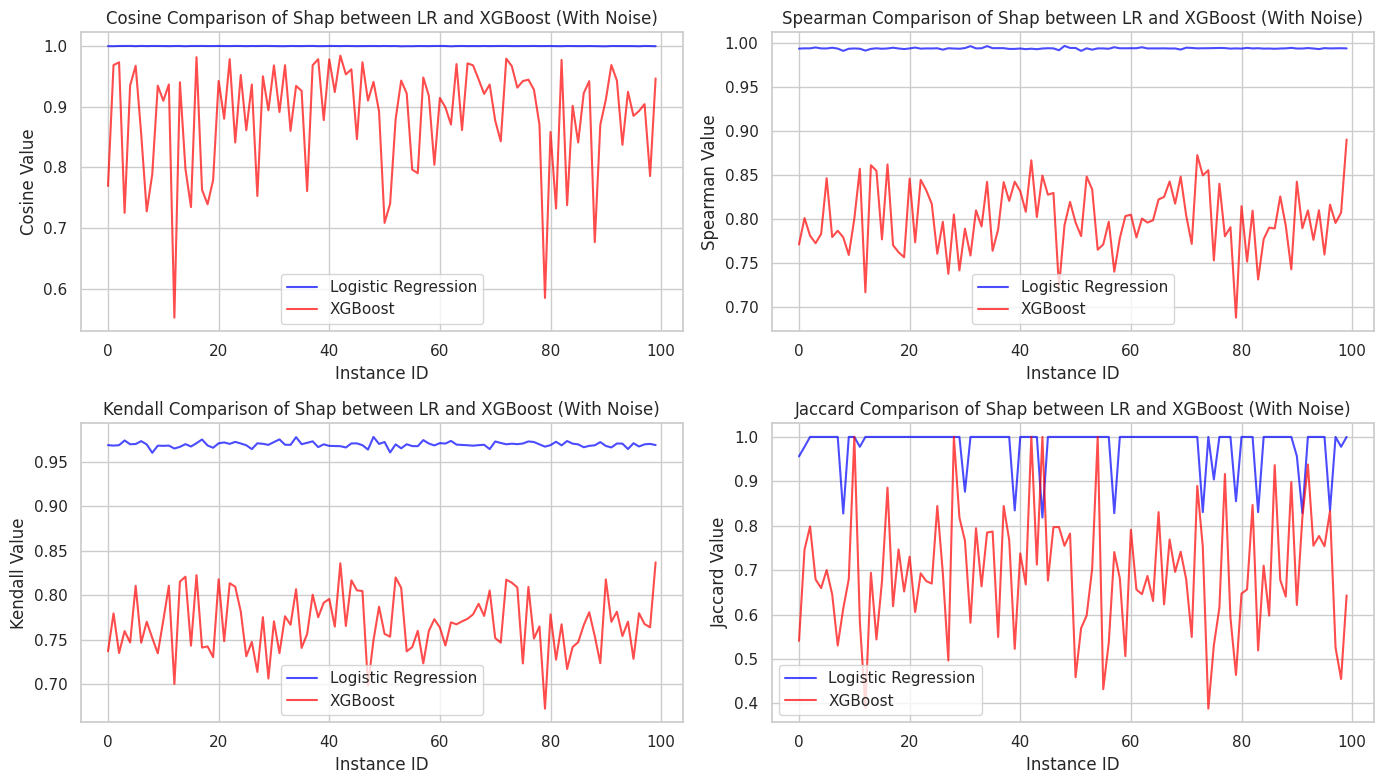

In [135]:
# Set up a seaborn style for better visualization
sns.set(style="whitegrid")

# List of metrics for consistency comparison
metrics = ['cosine', 'spearman', 'kendall', 'jaccard']

# Set the figure size
plt.figure(figsize=(14, 8))

# Loop through each metric and plot the comparison between the two models
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)  # Create subplots for each metric
    plt.plot(shap_local['instance_id'], shap_local[metric + '_lr'], label='Logistic Regression', color='blue', alpha=0.7)
    plt.plot(shap_local['instance_id'], shap_local[metric + '_xgb'], label='XGBoost', color='red', alpha=0.7)

    plt.xlabel('Instance ID')
    plt.ylabel(f'{metric.capitalize()} Value')
    plt.title(f'{metric.capitalize()} Comparison of Shap between LR and XGBoost (With Noise)')
    plt.legend()

plt.tight_layout()
plt.show()


_

### **iii. Wilcoxon Test**

In [140]:
# Wilcoxon Signed Rank Test for each metric
def wilcoxon_test(data_lr, data_xgb, metric_name):
    stat, p_value = wilcoxon(data_lr, data_xgb)
    print(f"Wilcoxon test for {metric_name}:")
    print(f"Test statistic = {stat:.3f}, p-value = {p_value:.3f}")

    if p_value < 0.05:
        print(f"Result: There is a significant difference in {metric_name} between Logistic Regression and XGBoost.")
    else:
        print(f"Result: No significant difference in {metric_name} between Logistic Regression and XGBoost.")
    print("\n" + "-"*50)

# Perform Wilcoxon Signed Rank Test for each metric
for lr_metric, xgb_metric in zip(metrics_lr, metrics_xgb):
    wilcoxon_test(shap_local[lr_metric], shap_local[xgb_metric], lr_metric.split('_')[0])


Wilcoxon test for cosine:
Test statistic = 0.000, p-value = 0.000
Result: There is a significant difference in cosine between Logistic Regression and XGBoost.

--------------------------------------------------
Wilcoxon test for spearman:
Test statistic = 0.000, p-value = 0.000
Result: There is a significant difference in spearman between Logistic Regression and XGBoost.

--------------------------------------------------
Wilcoxon test for kendall:
Test statistic = 0.000, p-value = 0.000
Result: There is a significant difference in kendall between Logistic Regression and XGBoost.

--------------------------------------------------
Wilcoxon test for jaccard:
Test statistic = 16.500, p-value = 0.000
Result: There is a significant difference in jaccard between Logistic Regression and XGBoost.

--------------------------------------------------


_

### **iv. Comparing Shap Explanation Stability Metrics Across Logistic Regression and XGBoost**

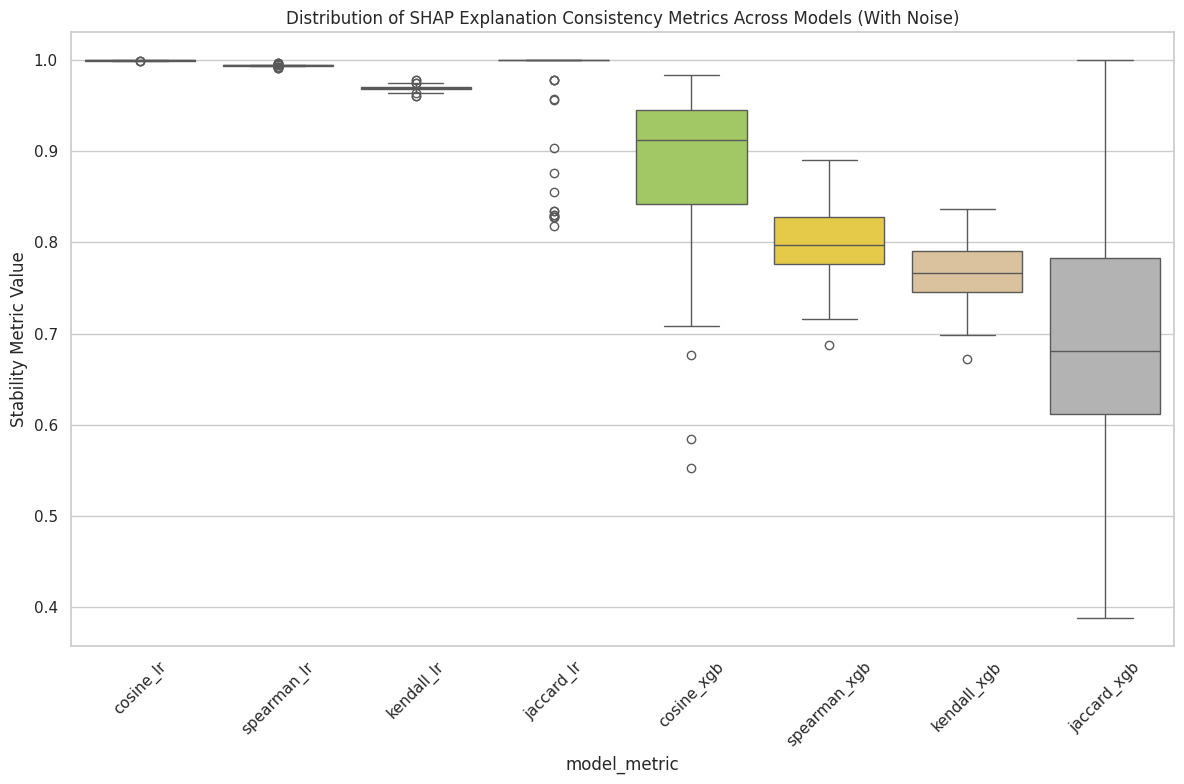

In [142]:
# Plot a boxplot for each metric across both models
plot_df = shap_local.melt(id_vars="instance_id", value_vars=metrics_lr + metrics_xgb,
                                     var_name="model_metric", value_name="value")

plt.figure(figsize=(12, 8))
sns.boxplot(x="model_metric", y="value", hue="model_metric", data=plot_df, palette="Set2")
plt.title("Distribution of SHAP Explanation Consistency Metrics Across Models (With Noise)")
plt.ylabel("Stability Metric Value")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


_

### **v. Summary Statistics of Metrices**

In [148]:
# Calculate summary statistics for both models
shap_summary = shap_local[['cosine_lr', 'cosine_xgb', 'spearman_lr', 'spearman_xgb', 'kendall_lr', 'kendall_xgb', 'jaccard_lr', 'jaccard_xgb']].describe()

# Print summary statistics
display(shap_summary)


,cosine_lr,cosine_xgb,spearman_lr,spearman_xgb,kendall_lr,kendall_xgb,jaccard_lr,jaccard_xgb
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.999710,0.882736,0.994257,0.799922,0.969677,0.767587,0.981157,0.695238
std,0.000136,0.090435,0.000843,0.038015,0.002937,0.033270,0.050139,0.138468
min,0.999312,0.552070,0.991444,0.687452,0.960333,0.672247,0.818391,0.388077
25%,0.999650,0.842222,0.994034,0.776515,0.968275,0.745716,1.000000,0.611624
50%,0.999730,0.912782,0.994272,0.797596,0.969811,0.766940,1.000000,0.680870
75%,0.999816,0.945108,0.994492,0.828060,0.970979,0.790629,1.000000,0.782895
max,0.999911,0.983929,0.997103,0.890443,0.978187,0.836969,1.000000,1.000000


_

_

## **GLOBAL ANALYSIS**

### **1. LIME**

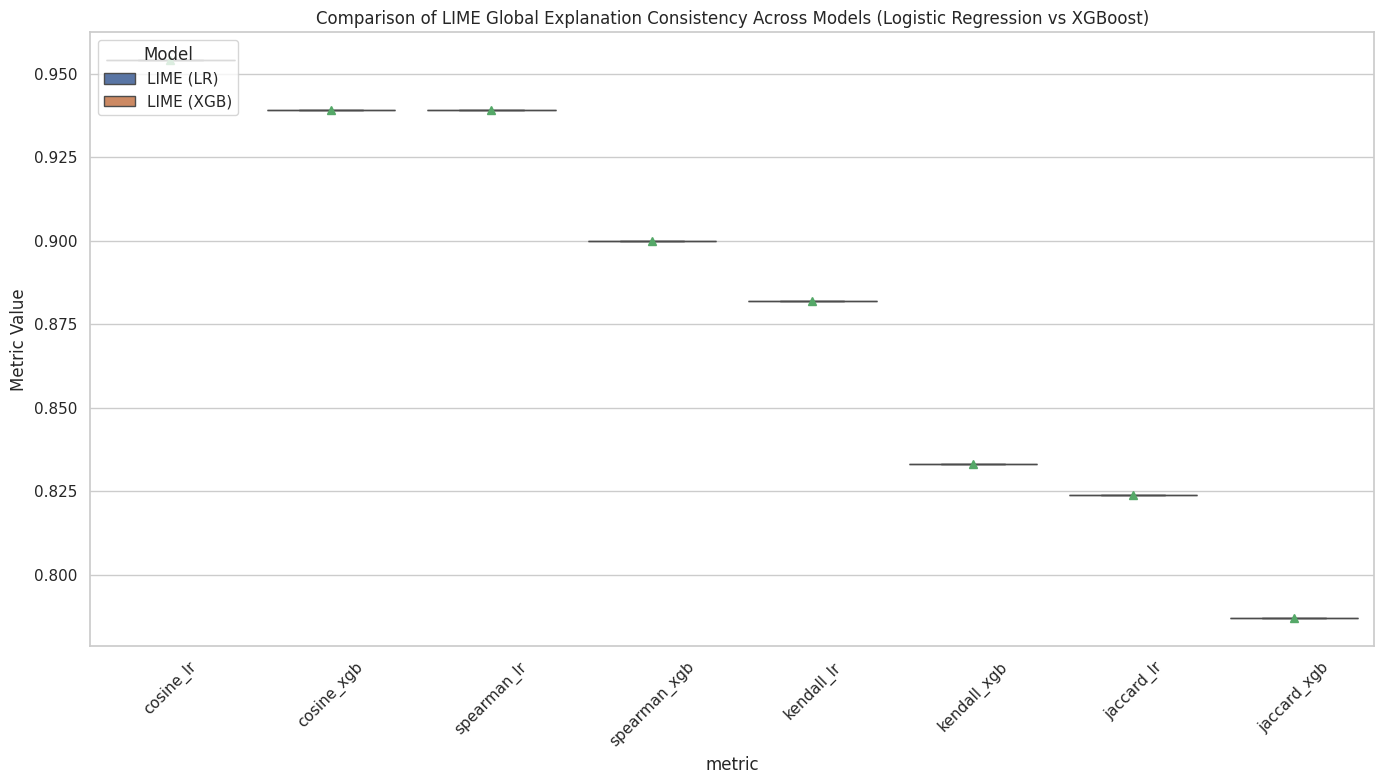

In [156]:
# Your DataFrame
data = {
    'cosine_lr': [0.954],
    'cosine_xgb': [0.939],
    'spearman_lr': [0.939],
    'spearman_xgb': [0.9],
    'kendall_lr': [0.882],
    'kendall_xgb': [0.833],
    'jaccard_lr': [0.824],
    'jaccard_xgb': [0.787]
}

# Convert it to DataFrame
lime_combined_df = pd.DataFrame(data)

# Reshape the DataFrame to long format using melt
lime_combined_df_melted = lime_combined_df.melt(var_name="metric", value_name="value")

# Add a 'model' column to differentiate between LR and XGB
lime_combined_df_melted['model'] = lime_combined_df_melted['metric'].apply(
    lambda x: 'LIME (LR)' if 'lr' in x else 'LIME (XGB)'
)

# Set up the seaborn style for better visualization
sns.set(style="whitegrid")

# Set up the figure size
plt.figure(figsize=(14, 8))

# Create the boxplot comparison between LR and XGB for each metric
sns.boxplot(x="metric", y="value", hue="model", data=lime_combined_df_melted, showmeans=True)

# Customize plot
plt.title("Comparison of LIME Global Explanation Consistency Across Models (Logistic Regression vs XGBoost)")
plt.ylabel("Metric Value")
plt.xticks(rotation=45)
plt.legend(title="Model", loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()


_